In [1]:
# Need to scale problem better
# Need to include the cost function

In [2]:
%reset # clears variables in workspace

# import libraries
from pyomo.environ import*
from pyomo.opt import SolverFactory
from pyomo.opt import SolverStatus, TerminationCondition
import sympy as sym
import numpy as np
from IPython.display import display
from sympy import pprint

# import EOM
import dill
dill.load_session('simplified_biped_FW.db')

func_map = {'sin':sin, 'cos':cos} 

sym_list = [g] + [LL] +\
           [masses[base] for base in bases] +\
           [masses[link,leg] for leg in legs for link in links] +\
           [lengths[base] for base in bases] +\
           [lengths[link,leg] for leg in legs for link in links] +\
           [inertias[base] for base in bases] +\
           [inertias[link,leg] for leg in legs for link in links] +\
           [x_body]+[y_body]+[th_body]+[th_disc] + [th[link,leg] for leg in legs for link in links if 'foot' not in link] +\
           [dx_body]+[dy_body]+[dth_body]+[dth_disc] + [dth[link,leg] for leg in legs for link in links if 'foot' not in link] +\
           [ddx_body]+[ddy_body]+[ddth_body]+[ddth_disc] + [ddth[link,leg] for leg in legs for link in links if 'foot' not in link] +\
           [tau['disc']]+\
           [tau['left',leg] for leg in legs] + [tau['right',leg] for leg in legs] +\
           [lamda['x',leg] for leg in legs] + [lamda['y',leg] for leg in legs] +\
           [GRF['x',leg] for leg in legs] + [GRF['y',leg] for leg in legs]

lamb_EOMs = {}

DOFs = ['x_body'] + ['y_body'] +['theta_body'] + ['theta_disc']

for leg in legs:
    for link in links:
        if 'foot' not in link:
            DOFs = DOFs + ['theta_{0}'.format(link+leg)]

for dof_i,dof in enumerate(DOFs):
    lamb_EOMs.update({dof: sym.lambdify(sym_list,EOMs[dof_i],modules = [func_map])})

    
# PARAMETERS:
masses_ = {'body': 5756.78/1000,
           'disc': (485/1000) + (800/1000), # motor + disc
           'ullA': 153.81/1000,
           'lllA': 346.45/1000,
           'urlA': 153.81/1000,
           'lrlA': 346.45/1000,
           'ullB': 153.81/1000,
           'lllB': 346.45/1000,
           'urlB': 153.81/1000,
           'lrlB': 346.45/1000}

lengths_ = {'body': 24/100,
            'disc': None,
            'ullA': 17.5/100,
            'lllA': 30.0/100,
            'urlA': 17.5/100,
            'lrlA': 30.0/100,
            'ullB': 17.5/100,
            'lllB': 30.0/100,
            'urlB': 17.5/100,
            'lrlB': 30.0/100}

''' ****** '''
disc_radius = 0.5*lengths_['ullA']

inertias_ = {'body': 32124078.52*1e-9, # body rotate about its center 
             'disc': 0.5*masses_['disc']*(disc_radius**2),
            'ullA': 600933.68*1e-9, # rotates as pendulumn 
            'urlA': 600933.68*1e-9,
            'lllA': 4659658.63*1e-9,
            'lrlA': 4659658.63*1e-9,
            'ullB': 600933.68*1e-9, # rotates as pendulumn 
            'urlB': 600933.68*1e-9,
            'lllB': 4659658.63*1e-9,
            'lrlB': 4659658.63*1e-9}

total_mass = 0.0
for mass in masses_:
    total_mass += masses_[mass]
total_mass

WDOFs = ['X','Y'] 
signs = ['-ve','+ve'] 
legs = ['A','B']
links = ['ull','lll','url','lrl']
bases = ['body','disc']
ground_constraints = ['contact','friction','slip_+ve','slip_-ve'] # Group all constraints occuring at the ground
sides = ['left','right']
coordinates = {'X':0 , 'Y':1}
motor_w_angle = {'left': 'ull' ,'right': 'url'}
all_links = []
for leg in legs:
    for link in links:
        all_links.append(link+leg)
        
[all_links.append(base) for base in bases]

def get_var_list_zeros(m,n):
    var_list = [m.g] + [m.LL] +\
               [m.masses[base] for base in bases] +\
               [m.masses[link+leg] for leg in legs for link in links] +\
               [m.lengths[base] for base in bases] +\
               [m.lengths[link+leg] for leg in legs for link in links] +\
               [m.inertias[base] for base in bases] +\
               [m.inertias[link+leg] for leg in legs for link in links] +\
               [m.q[n,dof] for dof in DOFs] +\
               [m.dq[n,dof] for dof in DOFs] +\
               [m.ddq[n,dof] for dof in DOFs] +\
               [0]+\
               [0 for leg in legs] + [0 for leg in legs] +\
               [0 for leg in legs] + [0 for leg in legs] +\
               [0 for leg in legs] + [0 for leg in legs]
    return var_list

def get_var_list_values(m,n):
    
    BW = 1
    tau_value = {}
    connection_force_value = {}
    GRF_X_value = {}
    GRF_Y_value = {}
    tau_value.update({('disc'): m.tau_torque_FW[n]})
    
    for leg in legs:
        
        [tau_value.update({(side,leg): BW*(m.tau_torque[n,side,leg])}) for side in sides]
        #[connection_force_value.update({(wdof,leg):BW*(m.connect_force[n,'+ve',wdof,leg]-m.connect_force[n,'-ve',wdof,leg])}) for wdof in WDOFs]
        #[connection_force_value.update({(wdof,leg):0.0})for wdof in WDOFs]
        [connection_force_value.update({(wdof,leg):BW*(m.connect_force[n,wdof,leg])}) for wdof in WDOFs]
        GRF_X_value.update({(leg):BW*(m.GRF_x[n,'+ve',leg]-m.GRF_x[n,'-ve',leg])})
        GRF_Y_value.update({(leg):BW*(m.GRF_y[n,leg])})

    var_list = [m.g] + [m.LL] +\
               [m.masses[base] for base in bases] +\
               [m.masses[link+leg] for leg in legs for link in links] +\
               [m.lengths[base] for base in bases] +\
               [m.lengths[link+leg] for leg in legs for link in links] +\
               [m.inertias[base] for base in bases] +\
               [m.inertias[link+leg] for leg in legs for link in links] +\
               [m.q[n,dof] for dof in DOFs] +\
               [m.dq[n,dof] for dof in DOFs] +\
               [m.ddq[n,dof] for dof in DOFs] +\
               [tau_value['disc']]+\
               [tau_value['left',leg] for leg in legs] + [tau_value['right',leg] for leg in legs] +\
               [connection_force_value['X',leg] for leg in legs] + [connection_force_value['Y',leg] for leg in legs] +\
               [GRF_X_value[leg] for leg in legs] + [GRF_Y_value[leg] for leg in legs]
    return var_list



Once deleted, variables cannot be recovered. Proceed (y/[n])? y
Don't know how to reset  #, please run `%reset?` for details
Don't know how to reset  clears, please run `%reset?` for details
Don't know how to reset  variables, please run `%reset?` for details
Flushing input history
Don't know how to reset  workspace, please run `%reset?` for details


--------------
Stall torque =  140.4238410596027
Max speed =  55.8
--------------


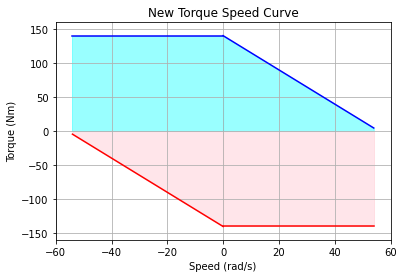

In [3]:
'''Plot Torque Speed Curve'''
import matplotlib.pyplot as plt
x_p = np.linspace(0, 54, num=54)
x_n = np.linspace(-54, 0, num=54)
no_load_speed = 55.8
# from graph
max_torque = 38.0
speed_max_torque = 40.7

m_grad = (max_torque-0.0)/(speed_max_torque-no_load_speed)

stall_torque = 0.0 - m_grad*no_load_speed

y_p = m_grad*x_p+stall_torque
y_n = m_grad*x_n-stall_torque

stall_torque_p = []
stall_torque_n = []
rated_torque_p = []
rated_torque_n = []

for ii in range(len(x_p)):
    stall_torque_p.append(stall_torque)
    stall_torque_n.append(-stall_torque)
    rated_torque_p.append(max_torque)
    rated_torque_n.append(-max_torque)

plt.grid()
plt.plot(x_p, y_p,'b')
plt.plot(x_n, stall_torque_p,'b')

plt.fill_between(x_p, y_p, alpha=0.4, color = 'cyan')
plt.fill_between(x_n, stall_torque_p, alpha=0.4,color = 'cyan')

plt.plot(x_n, y_n,'r')
plt.plot(x_p, stall_torque_n,'r')

plt.fill_between(x_n, y_n, alpha=0.4,color = 'pink')
plt.fill_between(x_p, stall_torque_n, alpha=0.4,color = 'pink')

plt.axis((-60,60,-160,160))
plt.title('New Torque Speed Curve')
plt.xlabel('Speed (rad/s)')
plt.ylabel('Torque (Nm)')
print('--------------')

print('Stall torque = ',stall_torque)
print('Max speed = ',no_load_speed)

print('--------------')

--------------
Stall torque =  41.53846153846154
Max speed =  45.0
--------------


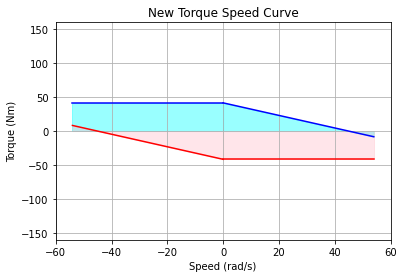

In [4]:
'''Plot Torque Speed Curve'''
import matplotlib.pyplot as plt

no_load_speed_FW = 45.0
# from graph
max_torque_FW = 12.0
speed_max_torque_FW = 32.0

m_grad_FW = (max_torque_FW-0.0)/(speed_max_torque_FW-no_load_speed_FW)

stall_torque_FW = 0.0 - m_grad_FW*no_load_speed_FW

y_p_FW = m_grad_FW*x_p+stall_torque_FW
y_n_FW = m_grad_FW*x_n-stall_torque_FW

stall_torque_p_FW = []
stall_torque_n_FW = []
rated_torque_p_FW = []
rated_torque_n_FW = []

for ii in range(len(x_p)):
    stall_torque_p_FW.append(stall_torque_FW)
    stall_torque_n_FW.append(-stall_torque_FW)
    rated_torque_p_FW.append(max_torque_FW)
    rated_torque_n_FW.append(-max_torque_FW)

plt.grid()
plt.plot(x_p, y_p_FW,'b')
plt.plot(x_n, stall_torque_p_FW,'b')

plt.fill_between(x_p, y_p_FW, alpha=0.4, color = 'cyan')
plt.fill_between(x_n, stall_torque_p_FW, alpha=0.4,color = 'cyan')

plt.plot(x_n, y_n_FW,'r')
plt.plot(x_p, stall_torque_n_FW,'r')

plt.fill_between(x_n, y_n_FW, alpha=0.4,color = 'pink')
plt.fill_between(x_p, stall_torque_n_FW, alpha=0.4,color = 'pink')

plt.axis((-60,60,-160,160))
plt.title('New Torque Speed Curve')
plt.xlabel('Speed (rad/s)')
plt.ylabel('Torque (Nm)')
print('--------------')

print('Stall torque = ',stall_torque_FW)
print('Max speed = ',no_load_speed_FW)

print('--------------')

In [5]:
FOR_LOOP_RUN = False

<a id='Select_Test'></a>

In [6]:
tests = {0:"High_Drop_Test",1:"Low_Drop_Test", 2:"Hop_Test", 3:"Drop_Hop_Test",\
         4:"Standing_Test", 5:"Tax_Day_Sprint",6:"Missing_the_Boat",\
         7:"Periodic_Hop",8:"Periodic_Run",9:"Stop_Periodic_Run_Flight",10:"Start_Periodic_Run",\
         11:"High_Drop_Move_Leg", 12:"Forward_Hop", 13:"Stop_Periodic_Run_MidStance"}


test = tests[8]
V_avg = 8.0
mu_value = 1.0
h_lower_bound = 0.5
h_higher_bound = 1.5

if test == "High_Drop_Test" or test == "Low_Drop_Test" or test == "Standing_Test":
    N = 50
    TT = 0.7
elif test == "High_Drop_Move_Leg":
    N = 50
    TT = 0.4
elif test == "Forward_Hop":
    N = 50
    TT = 0.7
    x_final = 2.0 # for display
elif test == "Hop_Test" or test == "Drop_Hop_Test":
    N = 50
    TT = 1.0
elif test == "Tax_Day_Sprint":
    N = 50
    TT = 1.5
    x_final = 5.0
elif test == "Missing_the_Boat":
    N = 50
    TT = 1.0
    x_final = 5.0
elif test == "Periodic_Hop":
    N = 50
    TT = 1.0 # 2Hz but only half a gait due to symmetry
    dy_periodic = 0.5
elif test == "Periodic_Run":
    # u 0.5 [N = 100 and TT = 0.15 0.5<h<1.5]
    # u 1.0 [N = 100 and TT = 0.3 0.8<h<1.2]
    N = 100 #50 #100
    TT = 0.3 #0.15 #0.5 #0.3 # 2Hz but only half a gait due to symmetry
    V_flight = 0.75*sqrt(9.81*(0.18+0.35)) # from paper
    x_final = 3.0 # for display

elif test == "Stop_Periodic_Run_Flight" or test == "Start_Periodic_Run" or test == "Stop_Periodic_Run_MidStance":

    import csv
    file = open(str(round(V_avg))+'_u1.0.csv'.format(str(mu_value)))
    csvreader = csv.reader(file)

    rows = []
    for row in csvreader:
        rows.append(row)

    stored_values = {}
    headers = rows[0]

    for item in rows:
        if item[0] == 'node': # remove headers
            pass
        else: 
            for header_loc in range(len(headers)):
                if header_loc == 0: # don't want 'node' as header - only its value
                    pass 
                else:
                    stored_values.update({(headers[header_loc],int(item[0])):float(item[header_loc])})

        #initial_conditions[item[0]] = float(item[1])
    x_final = 5.0 # for display 

    if test == "Stop_Periodic_Run_Flight":
        # done [100,1.5 and ]
        N = 100 #50
        TT = 1.0 # 1.0 2Hz but only half a gait due to symmetry
    elif test == "Stop_Periodic_Run_MidStance":
        N = 100
        TT = 1.0
    elif test == "Start_Periodic_Run":
        N = 50
        TT = 1.0
    else: pass   

else:
    pass



In [7]:
if 'Stop' in test: 
    GRF_yA_array = []
    GRF_yB_array = []
    for n in range (N):
        GRF_yA_array.append(stored_values['GRF_yA',n])
        GRF_yB_array.append(stored_values['GRF_yB',n])

    print(max(GRF_yA_array))
    print(max(GRF_yB_array))
    max_GRFA = max(GRF_yA_array)
    max_GRFB = max(GRF_yB_array)
    max_index = GRF_yB_array.index(max(GRF_yB_array))
    print(max_index)
    midstance_node = max_index+1
else: 
    pass

In [8]:
print("test = ",test)
print("total mass = " ,total_mass)
print("mu = ",mu_value)
print("V_avg = ",V_avg)
print("N = ",N)
print("TT = ",TT)

if TT/N < 0.01 or TT/N>0.02:
    print('Exceeded hm: ',TT/N)
else:
    print('Passed hm: ',TT/N)
    


test =  Periodic_Run
total mass =  9.042820000000003
mu =  1.0
V_avg =  8.0
N =  100
TT =  0.3
Exceeded hm:  0.003


In [9]:
m = ConcreteModel('Biped_wFW')

#SETS-------------------------
m.N = RangeSet(N)
m.ground_constraints = Set(initialize = ground_constraints)
m.legs = Set(initialize = legs)
m.links = Set(initialize = links)
m.bases = Set(initialize = bases)
m.all_links = Set(initialize = all_links)
m.DOFs = Set(initialize = DOFs)
m.WDOFs = Set(initialize = WDOFs)
m.signs = Set(initialize = signs)
m.sides = Set(initialize = sides)


#Params--------------------------
m.g = Param(initialize = 9.81)
m.LL = Param(initialize = 7.5/100)

# m.masses = Param(m.links, initialize = masses)
m.masses = Param(m.all_links, initialize = masses_)
m.lengths = Param(m.all_links, initialize = lengths_)
m.inertias = Param(m.all_links, initialize = inertias_)


#VARIABLES----------------------
#gen coordinates
m.q = Var(m.N,m.DOFs)
m.dq = Var(m.N,m.DOFs)
m.ddq = Var(m.N,m.DOFs)

    we will be changing that default to 'Reals' in the future.  If you really
    intend the domain of this Param (lengths) to be 'Any', you can suppress
    this warning by explicitly specifying 'within=Any' to the Param
    constructor.  (deprecated in 5.6.9, will be removed in 6.0) (called from
    /home/uct/anaconda3/envs/test-ipopt/lib/python3.9/site-
    packages/pyomo/core/base/param.py:77)


In [10]:
''' CONSTRAINTS  - Integration'''
# variable timestep
hm = TT/N # master timestep
m.h = Var(m.N, bounds = (h_lower_bound,h_higher_bound)) #m.h = Var(m.N, bounds = (0.5,1.5))

def BwEuler_p(m,n,dof):
    if n > 1:
        return m.q[n,dof] == m.q[n-1,dof] + hm*m.h[n]*m.dq[n,dof]
    else:
        return Constraint.Skip
m.integrate_p = Constraint(m.N, m.DOFs, rule = BwEuler_p)

def BwEuler_v(m,n,dof):
    if n > 1:
        return m.dq[n,dof] == m.dq[n-1,dof] + hm*m.h[n]*m.ddq[n,dof]
    else:
        return Constraint.Skip 
m.integrate_v = Constraint(m.N, m.DOFs, rule = BwEuler_v)

In [11]:
''' CONSTRAINTS  - CONNECTION POINT'''
m.connect_position = Var(m.N, m.WDOFs, m.sides, m.legs) # connection point
m.connect_force = Var(m.N, m.WDOFs, m.legs,bounds = (-10*total_mass*9.81,10*total_mass*9.81)) # connection force

# Lamdify
lamb_connect_position = {} # (WDOFs,sides,leg)
[lamb_connect_position.update({(wdof,side,leg): sym.lambdify(sym_list,connect_foot_position[side,leg][coordinates[wdof]],modules = [func_map])}) for leg in legs for side in sides for wdof in WDOFs]

# Equate the connection equations from the previous script to the model m
def def_connect_position_equation(m,n,wdof,side,leg):
    var_list = get_var_list_zeros(m,n)    
    return m.connect_position[n,wdof,side,leg] == lamb_connect_position[wdof,side,leg](*var_list)
m.connect_position_equation = Constraint(m.N, m.WDOFs, m.sides, m.legs, rule = def_connect_position_equation)

# Ensure that there is no distance between the X (and Y) of link connection points
def def_connect_position(m,n,wdof,leg):
    return  m.connect_position[n,wdof,'right',leg] - m.connect_position[n,wdof,'left',leg] == 0.0
m.connect_position_constraint = Constraint(m.N, m.WDOFs, m.legs, rule= def_connect_position)

In [12]:
#Variable of foot position
m.foot_position = Var(m.N, m.WDOFs, m.legs)
for n in range(1,N+1):
    for leg in legs:
        m.foot_position[n,'Y',leg].setlb(0.0)

#Get the foot position in WDOF
lamb_foot_position = {}
[lamb_foot_position.update({(wdof,leg): sym.lambdify(sym_list,connect_foot_position['right',leg][coordinates[wdof]],modules = [func_map])}) for leg in legs for wdof in WDOFs]

def def_foot_position(m,n,wdof,leg):
    var_list = get_var_list_zeros(m,n)
    return m.foot_position[n,wdof,leg] == lamb_foot_position[wdof,leg](*var_list)
m.def_foot_position = Constraint(m.N, m.WDOFs, m.legs, rule = def_foot_position)

m.mu = Param(initialize = mu_value,within=Any)

# Variables
m.foot_velocity = Var(m.N, m.WDOFs, m.signs, m.legs, bounds = (0.0,None)) # the sign will account for -ve velocities
m.friction_cone = Var(m.N, m.legs, bounds = (0.0,None)) 
m.GRF_y = Var(m.N, m.legs, bounds = (0.0,10*total_mass*m.g.value)) # ground reaction forces
m.GRF_x = Var(m.N, m.signs, m.legs, bounds = (0.0,10*total_mass*m.g.value)) # ground reaction forces

'''******'''
m.ground_penalty = Var(m.N, m.ground_constraints, m.legs, bounds = (0.0,10.0)) # penalty

lamb_foot_velocity_x = {}

# Get the foot position in WDOF
[lamb_foot_velocity_x.update({(leg): sym.lambdify(sym_list,(connect_foot_position['right',leg].jacobian(q)*dq)[0].simplify(),modules = [func_map])}) for leg in legs]

# CONSTRAINTS
def def_foot_velocity(m,n,wdof,leg):
    if wdof == 'X':
        var_list = get_var_list_zeros(m,n)
        return m.foot_velocity[n,'X','+ve',leg]-m.foot_velocity[n,'X','-ve',leg] == lamb_foot_velocity_x[leg](*var_list)
    else: return Constraint.Skip
m.foot_velocity_constraint = Constraint(m.N, m.WDOFs, m.legs, rule = def_foot_velocity)

def def_friction_cone(m,n,leg):
    return m.friction_cone[n,leg] == m.mu*m.GRF_y[n,leg] - (m.GRF_x[n,'+ve',leg] + m.GRF_x[n,'-ve',leg])
m.friction_cone_constraint = Constraint(m.N, m.legs, rule = def_friction_cone)

# constraints: complementarity

# contact
def def_ground_contact(m,n,leg):
    if n < N:
        return m.foot_position[n+1,'Y',leg]*m.GRF_y[n,leg] <= m.ground_penalty[n,'contact',leg]
    else:
        return Constraint.Skip
m.ground_contact_constraint = Constraint(m.N, m.legs, rule = def_ground_contact)

# friction
def def_ground_friction(m,n,leg):
    return (m.foot_velocity[n,'X','+ve',leg]+m.foot_velocity[n,'X','-ve',leg])*m.friction_cone[n,leg] <= m.ground_penalty[n,'friction',leg]
m.ground_friction_constraint = Constraint(m.N, m.legs, rule = def_ground_friction)

# slipping
def def_ground_slip_positive(m,n,leg):
    return m.foot_velocity[n,'X','+ve',leg]*m.GRF_x[n,'+ve',leg] <= m.ground_penalty[n,'slip_+ve',leg]
m.ground_slip_positive_constraint = Constraint(m.N, m.legs, rule = def_ground_slip_positive)

def def_ground_slip_negative(m,n,leg):
    return m.foot_velocity[n,'X','-ve',leg]*m.GRF_x[n,'-ve',leg] <= m.ground_penalty[n,'slip_-ve',leg]
m.ground_slip_negative_constraint = Constraint(m.N, m.legs, rule = def_ground_slip_negative)

#bound contact forces at last node
for leg in legs:
    m.GRF_y[N,leg].fix(0.0)
    for sgn in signs:
        m.GRF_x[N,sgn,leg].fix(0.0)


In [13]:
'''Torque Speed - Speed Torque Curve'''

m.tau_torque = Var(m.N, m.sides, m.legs, bounds = (-max_torque,max_torque))
m.tau_velocity = Var(m.N, m.sides, m.legs, bounds = (-no_load_speed,no_load_speed))

lamb_tau_velocity = {}
[lamb_tau_velocity.update({(side,leg): sym.lambdify(sym_list,w_links[motor_w_angle[side],leg],modules = [func_map])}) for leg in legs for side in sides]

def def_angular_velocity(m,n,side,leg):
    var_list = get_var_list_zeros(m,n)
    return m.tau_velocity[n,side,leg] == lamb_tau_velocity[side,leg](*var_list)
m.left_angular_velocity_constraint = Constraint(m.N, m.sides, m.legs, rule = def_angular_velocity)

# assume straight line
def def_constant_power_right(m,n,side,leg):
    return m.tau_torque[n,side,leg] <= m.tau_velocity[n,side,leg]*m_grad + stall_torque
m.constant_power_right_constraint = Constraint(m.N, m.sides, m.legs, rule = def_constant_power_right)

def def_constant_power_left(m,n,side,leg):
    return m.tau_torque[n,side,leg] >= m.tau_velocity[n,side,leg]*m_grad - stall_torque
m.constant_power_left_constraint = Constraint(m.N, m.sides, m.legs, rule = def_constant_power_left)

In [14]:
'''Torque Speed FW'''

m.tau_torque_FW = Var(m.N, bounds = (-max_torque_FW,max_torque_FW))
m.tau_velocity_FW = Var(m.N, bounds = (-no_load_speed_FW,no_load_speed_FW))

lamb_tau_velocity_FW = sym.lambdify(sym_list,w_bases['disc'],modules = [func_map])

def def_angular_velocity_FW(m,n):
    var_list = get_var_list_zeros(m,n)
    return m.tau_velocity_FW[n] == lamb_tau_velocity_FW(*var_list)
m.left_angular_velocity_FW_constraint = Constraint(m.N, rule = def_angular_velocity_FW)

# assume straight line
def def_constant_power_right_FW(m,n):
    return m.tau_torque_FW[n] <= m.tau_velocity_FW[n]*m_grad_FW + stall_torque_FW
m.constant_power_right_FW_constraint = Constraint(m.N, rule = def_constant_power_right_FW)

def def_constant_power_left_FW(m,n):
    return m.tau_torque_FW[n] >= m.tau_velocity_FW[n]*m_grad_FW - stall_torque_FW
m.constant_power_left_FW_constraint = Constraint(m.N, rule = def_constant_power_left_FW)

In [15]:
# Set the angles for the knees - only use this when actuated 
# This ensures links does not cross
m.knee_angle = Var(m.N, m.sides, m.legs, bounds = (0.0,170*(np.pi)/180))

def def_knee_angle(m,n,side,leg):
    if side == 'left':
        return m.knee_angle[n,side,leg] == 2*np.pi - m.q[n,'theta_lll'+leg]
    else:
        return m.knee_angle[n,side,leg] == m.q[n,'theta_lrl'+leg]   
m.knee_angle_constraint = Constraint(m.N, m.sides, m.legs, rule = def_knee_angle)

In [16]:
# Get the foot position in WDOF
if test == "Periodic_Run" or test == "Periodic_Hop":
    
    lamb_body_position_x = sym.lambdify(sym_list,(r_bases['body'])[0].simplify(),modules = [func_map])
    m.body_position = Var(m.N, m.WDOFs) # the sign will account for -ve velocities

    # CONSTRAINTS
    def def_body_position(m,n,wdof):
        var_list = get_var_list_zeros(m,n)
        if wdof == 'X':
            return m.body_position[n,'X'] == lamb_body_position_x(*var_list)
        else: return Constraint.Skip
    m.body_position_constraint = Constraint(m.N, m.WDOFs, rule = def_body_position)
    
    
    if test == "Periodic_Run":
        
        # Average velocities
        def def_body_position_average(m,wdof):
            if wdof == 'X':
                return (m.body_position[N,'X'] - m.body_position[1,'X'])/(sum(hm*m.h[n] for n in range(1,N+1))) == V_avg
            else: return Constraint.Skip
        m.def_body_position_average_constraint = Constraint(m.WDOFs, rule = def_body_position_average)
        
        # Equate states
        def def_equate_position_states(m,n,dof_i):
            if dof_i == 'y_body' or dof_i == 'theta_body':# or dof_i == 'theta_disc':
                return m.q[1,dof_i] == m.q[N,dof_i]
            
            elif dof_i == 'theta_ullA':
                return m.q[1,'theta_ullA'] == m.q[N,'theta_ullB']
            elif dof_i == 'theta_ullB':
                return m.q[1,'theta_ullB'] == m.q[N,'theta_ullA']
            
            elif dof_i == 'theta_urlA':
                return m.q[1,'theta_urlA'] == m.q[N,'theta_urlB']
            elif dof_i == 'theta_urlB':
                return m.q[1,'theta_urlB'] == m.q[N,'theta_urlA']
            
            elif dof_i == 'theta_lllA':
                return m.q[1,'theta_lllA'] == m.q[N,'theta_lllB']
            elif dof_i == 'theta_lllB':
                return m.q[1,'theta_lllB'] == m.q[N,'theta_lllA']
            
            elif dof_i == 'theta_lrlA':
                return m.q[1,'theta_lrlA'] == m.q[N,'theta_lrlB']
#             elif dof_i == 'theta_lrlB':
#                 return m.q[1,'theta_lrlB'] == m.q[N,'theta_lrlA']
            else: 
                 return Constraint.Skip
        m.def_equate_position_states_constraint = Constraint(m.N, m.DOFs, rule = def_equate_position_states) 

        
        def def_equate_vel_states(m,n,dof_i):
            return m.dq[1,dof_i] == m.dq[N,dof_i]
        m.def_equate_vel_states_constraint = Constraint(m.N, m.DOFs,rule = def_equate_vel_states)
  
    
        # Condition where the GRF can't increase twice from zero          
    
    
    else: 
        
        def def_equate_position_states(m,n,dof_i):
            return m.q[1,dof_i] == m.q[N,dof_i]
        m.def_equate_position_states_constraint = Constraint(m.N, m.DOFs,rule = def_equate_position_states)
        
        def def_equate_vel_states(m,n,dof_i):
            return m.dq[1,dof_i] == m.dq[N,dof_i]
        m.def_equate_vel_states_constraint = Constraint(m.N, m.DOFs,rule = def_equate_vel_states)

else: pass
                                    


In [17]:
''' Use this code for tests '''

# BOUND VALUES
sign_symbols = ['+','-']
boundaries = ['setub','setlb']
for n in range(1,N+1):
    for leg in legs:
        for index in range(len(boundaries)):
            eval('m.q[n,\'theta_ull\'+leg].{0}(np.pi*(0.5{1}1/2))'.format(boundaries[index],sign_symbols[index]))
            eval('m.q[n,\'theta_lll\'+leg].{0}(np.pi*(1{1}1/2))'.format(boundaries[index],sign_symbols[index]))  
            eval('m.q[n,\'theta_url\'+leg].{0}(np.pi*(0.5{1}1/2))'.format(boundaries[index],sign_symbols[index]))    
            eval('m.q[n,\'theta_lrl\'+leg].{0}(np.pi*(1{1}1/2))'.format(boundaries[index],sign_symbols[index]))

    m.q[n,'theta_body'].setub(np.pi*(1/4))
    m.q[n,'theta_body'].setlb(np.pi*(-1/4))
        
    if test == "Periodic_Run":
        m.q[n,'y_body'].setub(1.0)
        m.dq[1,'y_body'].fix(0.0)
        
#         m.dq[1,'theta_UL'].fix(0.0)
#         m.dq[1,'theta_UR'].fix(0.0)
        
    elif test == "Periodic_Hop":
        m.dq[1,'y_body'].fix(0.0)   
        
    elif test == "Forward_Hop":
        m.q[n,'y_body'].setub(2.0)
        for dof in DOFs:
            m.dq[1,dof].fix(0.0)
            
    elif test == "Stop_Periodic_Run_MidStance" or test == "Stop_Periodic_Run_Flight":
        pass
    
    else:
        for dof in DOFs:
            m.dq[1,dof].fix(0.0)
    
    if test == "High_Drop_Test" or test == "Low_Drop_Test" or test == "Standing_Test" or test == "Drop_Hop_Test" or test =="Periodic_Hop" or test == "High_Drop_Move_Leg":

        # Set graph limits 
        x_low_lim = -1.0
        x_high_lim = 1.0
        y_low_lim = -0.5
        y_high_lim = 2.0
        
    
        if test == "Drop_Hop_Test" or test == "Periodic_Hop" or test == "High_Drop_Move_Leg":
            
            [m.tau_torque[1,side,leg].fix(0.0) for side in sides for leg in legs]
            m.tau_torque_FW[1].fix(0.0)
            
        else:
            
            [m.tau_torque[n,side,leg].fix(0.0) for side in sides for leg in legs]
            m.tau_torque_FW[n].fix(0.1)
    else:
    
        # Set graph limits 
        x_low_lim = -1.0
        x_high_lim = x_final + 1.0
        y_low_lim = -0.5
        y_high_lim = 1.5
    
        if test == "Periodic_Run" or test == "Stop_Periodic_Run_MidStance" or test == "Stop_Periodic_Run_Flight":
            pass
        else:
            [m.tau_torque[1,side,leg].fix(0.0) for side in sides for leg in legs]
            m.tau_torque_FW[1].fix(0.0)

<a id='initial_conditions'></a>

In [18]:
if test == "High_Drop_Test":
    #  ----------------------------- HIGH DROP TEST ---------------------------

    # initial condition
    m.q[1,'x_body'].fix(0.0)
    m.q[1,'y_body'].fix(1.7)
    m.q[1,'theta_body'].fix(np.pi*(0.0))
    m.q[1,'theta_disc'].fix(np.pi*(0.0))

    m.q[1,'theta_ullA'].fix(np.pi*(0.5-1/7))
    m.q[1,'theta_urlA'].fix(np.pi*(0.5+1/7))

    m.q[1,'theta_ullB'].fix(np.pi*(0.5-1/10))
    m.q[1,'theta_urlB'].fix(np.pi*(0.5+1/10))
        
elif test == "High_Drop_Move_Leg":
    #  ----------------------------- HIGH DROP MOVE LEG TEST ---------------------------

    # initial condition
    m.q[1,'x_body'].fix(0.0)
    m.q[1,'y_body'].fix(1.0)
    m.q[1,'theta_body'].fix(np.pi*(0.0))

    m.q[1,'theta_ullA'].fix(np.pi*(0.5-1/7))
    m.q[1,'theta_urlA'].fix(np.pi*(0.5+1/7))

    m.q[1,'theta_ullB'].fix(np.pi*(0.5-1/10))
    m.q[1,'theta_urlB'].fix(np.pi*(0.5+1/10))
    
    m.foot_position[N, 'X', 'A'].fix(0.1)
    m.foot_position[N, 'X', 'B'].fix(-0.1)
    
elif test == "Forward_Hop":
    #  ----------------------------- FORWARD HOP TEST ---------------------------

    # initial condition
    m.q[1,'x_body'].fix(0.0)
    m.q[1,'theta_body'].fix(np.pi*(0.0))

    m.foot_position[1, 'X', 'A'].fix(0.0)
    m.foot_position[1, 'X', 'B'].fix(0.0)
    m.foot_position[1, 'Y', 'A'].fix(0.0)
    m.foot_position[1, 'Y', 'B'].fix(0.0)

    m.q[N,'x_body'].setlb(1.5)
    
elif test == "Low_Drop_Test":
    #  ----------------------------- LOW DROP TEST ---------------------------

    # initial condition

    # initial condition
    m.q[1,'x_body'].fix(0.0)
    m.q[1,'theta_body'].fix(np.pi*(0.0))
    m.foot_position[1, 'Y', 'A'].fix(0.12)
    m.foot_position[1, 'Y', 'B'].fix(0.12)
    m.q[1,'theta_disc'].fix(np.pi*(0.0))

    m.q[1,'theta_ullA'].fix(np.pi*(0.5-1/7))
    m.q[1,'theta_urlA'].fix(np.pi*(0.5+1/7))

    m.q[1,'theta_ullB'].fix(np.pi*(0.5-1/7))
    m.q[1,'theta_urlB'].fix(np.pi*(0.5+1/7))

        
elif test == "Hop_Test":
    #  ----------------------------- HOP TEST ---------------------------

    # initial condition
    m.q[1,'y_body'].fix(0.35)
    m.q[1,'x_body'].fix(0.0)
    m.q[1,'theta_body'].fix(np.pi*(0.0))
    m.foot_position[1, 'Y', 'A'].fix(0.0)
    m.foot_position[1, 'Y', 'B'].fix(0.0)
    m.foot_position[1, 'X', 'A'].fix(0.0)
    m.foot_position[1, 'X', 'B'].fix(0.0)
        
    m.q[N,'y_body'].setlb(0.8)

elif test == "Drop_Hop_Test":
    
    # initial condition
    m.q[1,'x_body'].fix(0.0)
    m.q[1,'y_body'].fix(1.0)
    m.q[1,'theta_body'].fix(np.pi*(0.0))
    
#     m.q[1,'theta_ullA'].fix(np.pi*(0.5-1/7))
#     m.q[1,'theta_urlA'].fix(np.pi*(0.5+1/7))

#     m.q[1,'theta_ullB'].fix(np.pi*(0.5-1/7))
#     m.q[1,'theta_urlB'].fix(np.pi*(0.5+1/7))
        
    m.foot_position[round(N/5), 'Y', 'A'].setub(0.05)
    m.foot_position[round(N/5), 'Y', 'B'].setub(0.05)
        
    m.q[N,'y_body'].setlb(0.8)
    m.q[N,'x_body'].setub(0.7)
    m.q[N,'x_body'].setlb(0.3)
    
elif test == "Standing_Test":
    
    # initial condition
    m.q[1,'x_body'].fix(0.5)
    m.q[1,'theta_body'].fix(np.pi*(0.0))
 
    m.foot_position[1, 'Y', 'A'].fix(0.0)
    m.foot_position[1, 'Y', 'B'].fix(0.0)
     
    m.foot_position[N, 'Y', 'A'].fix(0.0)
    m.foot_position[N, 'Y', 'B'].fix(0.0)
    
elif test == 'Tax_Day_Sprint':
    
    # INITIALIZE ----------------------------------------------------------------------------------------------------------------
    guide = np.linspace(0,x_final,N)
    for n in range(1,N+1):
        m.GRF_y[n,'A'].value = np.random.uniform(0.0,1)
        m.GRF_x[n,'+ve','A'].value = m.mu.value*m.GRF_y[n,'A'].value
        m.GRF_y[n,'B'].value = np.random.uniform(0.0,1)
        m.GRF_x[n,'+ve','B'].value = m.mu.value*m.GRF_y[n,'B'].value
        
#         m.q[n,'x'].value = guide[n-1] + np.random.uniform(-0.25,0.25)
#         m.q[n,'y'].value  = np.random.uniform(0.5,1.1)
#         m.q[n,'theta_b'].value  = np.random.uniform(-np.pi/8,np.pi/8)
#         m.q[n,'theta_l'].value  = np.random.uniform(-np.pi/4,np.pi/4)
#         m.q[n,'r'].value  = np.random.uniform(0.0,0.5)
        
    # SPRINT --------------------------------------------------------------------------------------------------------------------
    # tax day

    # initial condition
    m.q[1,'x_body'].fix(0.0)
    m.q[1,'theta_body'].fix(0.0)
    
    m.q[1,'theta_ullA'].fix(np.pi*(0.5))
    m.q[1,'theta_urlA'].fix(np.pi*(0.5))
    m.q[1,'theta_ullB'].fix(np.pi*(0.5))
    m.q[1,'theta_urlB'].fix(np.pi*(0.5))
        
    m.foot_position[1, 'Y', 'A'].fix(0.0)
    m.foot_position[1, 'Y', 'B'].fix(0.0)

    # final condition
    m.q[N,'x_body'].setlb(x_final)

    m.dq[N,'x_body'].fix(0.0)
    m.dq[N,'theta_body'].fix(0.0)
    
    m.dq[N,'theta_ullA'].fix(0.0)
    m.dq[N,'theta_urlA'].fix(0.0)
    m.dq[N,'theta_ullB'].fix(0.0)
    m.dq[N,'theta_urlB'].fix(0.0)

    m.q[N,'theta_body'].fix(0.0)

    m.foot_position[N, 'Y', 'A'].fix(0.0)
    m.foot_position[N, 'Y', 'B'].fix(0.0)

    #m.pprint()
    
elif test ==  "Missing_the_Boat":
    # initial condition
    m.q[1,'x_body'].fix(0.0)
    m.q[1,'theta_body'].fix(0.0)
    m.foot_position[1, 'Y', 'A'].fix(0.0)
    m.foot_position[1, 'Y', 'B'].fix(0.0)
    m.q[N,'x_body'].setlb(x_final)

elif test == "Periodic_Hop":
    m.q[1,'y_body'].fix(1.0) # initial condition  
    m.q[1,'x_body'].fix(0.0) # initial condition  
    
    m.q[1,'theta_UL'].fix(0.0)
    m.q[1,'theta_UR'].fix(0.0)
    
    m.dq[1,'theta_UL'].fix(0.0)
    m.dq[1,'theta_UR'].fix(0.0)
    m.dq[1,'{r_prismatic}_{footL}'].fix(0.0)
    m.dq[1,'{r_prismatic}_{footR}'].fix(0.0)
    
    m.dq[N,'y_body'].fix(0.0) # initial condition
    
elif test == "Periodic_Run":
    # INITIALIZE ----------------------------------------------------------------------------------------------------------------
    guide = np.linspace(0,TT*V_avg,N)
    for n in range(1,N+1):
        m.q[n,'x_body'].value = guide[n-1] #+ np.random.uniform(-0.25,0.25)
#         m.q[n,'y'].value  = np.random.uniform(0.5,1.1)
#         m.q[n,'theta_b'].value  = np.random.uniform(-np.pi/8,np.pi/8)
#         m.q[n,'theta_l'].value  = np.random.uniform(-np.pi/4,np.pi/4)
#         m.q[n,'r'].value  = np.random.uniform(0.0,0.5)

#         m.GRF[n,'Y','ps'].value = np.random.uniform(0.0,1)
#         m.GRF[n,'X','ps'].value = m.mu.value*m.GRF[n,'Y','ps'].value
        

    m.q[1,'x_body'].fix(0.0) # initial condition
    m.q[1,'theta_body'].fix(0.0)
    #m.q[1,'theta_disc'].fix(0.0)
    
    m.q[1,'theta_ullA'].setub(np.pi*(0.5-1/7))
    m.q[1,'theta_urlA'].setub(np.pi*(0.5-1/7))
    
    m.q[1,'theta_ullB'].setlb(np.pi*(0.5+1/7))
    m.q[1,'theta_urlB'].setlb(np.pi*(0.5+1/7))
    
    for n in range(1,N+1):
        m.GRF_y[n,'A'].fix(0.0)
        m.foot_position[n, 'Y', 'A'].setlb(0.05)
    
    m.GRF_y[1,'B'].fix(0.0)
    

elif test == "Stop_Periodic_Run_Flight" or test == "Stop_Periodic_Run_MidStance":
    
#     guide = np.linspace(0,TT*V_avg,N)
#     for n in range(1,N+1):
#         m.q[n,'x_body'].value = guide[n-1]
    if test == "Stop_Periodic_Run_Flight":
        m.q[1,'x_body'].fix(stored_values['x_body',0]) # initial condition
        m.q[1,'y_body'].fix(stored_values['y_body',0])
        m.q[1,'theta_body'].fix(stored_values['theta_body',0])

        m.q[1,'theta_ullA'].fix(stored_values['theta_ullA',0])
        m.q[1,'theta_urlA'].fix(stored_values['theta_urlA',0])
        m.q[1,'theta_ullB'].fix(stored_values['theta_ullB',0])
        m.q[1,'theta_urlB'].fix(stored_values['theta_urlB',0])

        m.q[1,'theta_lllA'].fix(stored_values['theta_lllA',0])
        m.q[1,'theta_lrlA'].fix(stored_values['theta_lrlA',0])
        m.q[1,'theta_lllB'].fix(stored_values['theta_lllB',0])
        m.q[1,'theta_lrlB'].fix(stored_values['theta_lrlB',0])

        m.GRF_y[1,'A'].fix(0.0)
        m.GRF_y[1,'B'].fix(0.0)

        m.dq[1,'x_body'].fix(stored_values['dx_body',0]) # initial condition
        m.dq[1,'y_body'].fix(stored_values['dy_body',0])
        m.dq[1,'theta_body'].fix(stored_values['dtheta_body',0])
        m.dq[1,'theta_ullA'].fix(stored_values['dtheta_ullA',0])
        m.dq[1,'theta_urlA'].fix(stored_values['dtheta_urlA',0])
        m.dq[1,'theta_ullB'].fix(stored_values['dtheta_ullB',0])
        m.dq[1,'theta_urlB'].fix(stored_values['dtheta_urlB',0])

        m.dq[1,'theta_lllA'].fix(stored_values['dtheta_lllA',0])
        m.dq[1,'theta_lrlA'].fix(stored_values['dtheta_lrlA',0])
        m.dq[1,'theta_lllB'].fix(stored_values['dtheta_lllB',0])
        m.dq[1,'theta_lrlB'].fix(stored_values['dtheta_lrlB',0])
        
    else:
        print('here')
        
        
        m.GRF_y[1,'A'].fix(max_GRFA)
        m.GRF_y[1,'B'].fix(max_GRFB)
        
        m.q[1,'x_body'].fix(0.0) # initial condition
        m.q[1,'y_body'].fix(stored_values['y_body',max_index])
        m.q[1,'theta_body'].fix(stored_values['theta_body',max_index])

        m.q[1,'theta_ullA'].fix(stored_values['theta_ullA',max_index])
        m.q[1,'theta_urlA'].fix(stored_values['theta_urlA',max_index])
        m.q[1,'theta_ullB'].fix(stored_values['theta_ullB',max_index])
        m.q[1,'theta_urlB'].fix(stored_values['theta_urlB',max_index])

        m.q[1,'theta_lllA'].fix(stored_values['theta_lllA',max_index])
        m.q[1,'theta_lrlA'].fix(stored_values['theta_lrlA',max_index])
        m.q[1,'theta_lllB'].fix(stored_values['theta_lllB',max_index])
        m.q[1,'theta_lrlB'].fix(stored_values['theta_lrlB',max_index])

        m.dq[1,'x_body'].fix(stored_values['dx_body',max_index]) # initial condition
        m.dq[1,'y_body'].fix(stored_values['dy_body',max_index])
        m.dq[1,'theta_body'].fix(stored_values['dtheta_body',max_index])
        m.dq[1,'theta_ullA'].fix(stored_values['dtheta_ullA',max_index])
        m.dq[1,'theta_urlA'].fix(stored_values['dtheta_urlA',max_index])
        m.dq[1,'theta_ullB'].fix(stored_values['dtheta_ullB',max_index])
        m.dq[1,'theta_urlB'].fix(stored_values['dtheta_urlB',max_index])

        m.dq[1,'theta_lllA'].fix(stored_values['dtheta_lllA',max_index])
        m.dq[1,'theta_lrlA'].fix(stored_values['dtheta_lrlA',max_index])
        m.dq[1,'theta_lllB'].fix(stored_values['dtheta_lllB',max_index])
        m.dq[1,'theta_lrlB'].fix(stored_values['dtheta_lrlB',max_index])

#     for n5 in range(N-5,N+1): # last 5 nodes 
#         m.dq[n5,'x_body'].setub(0.0)

    
    for n5 in range(N-5,N+1): # last 5 nodes 
        for dof_i in DOFs:
            if dof_i == 'x_body':
                m.dq[n5,dof_i].setub(0.0)
            elif dof_i == 'theta_body':
                m.dq[n5,dof_i].setub(0.0) # CCW is +ve so body will lean backwards
            else:
                pass
                #m.dq[n5,dof_i].setub(0.05*m.dq[1,dof_i])
                
        m.foot_position[n5, 'Y', 'A'].fix(0.0)
        m.foot_position[n5, 'Y', 'B'].fix(0.0)
    
elif test == "Start_Periodic_Run":
    guide = np.linspace(0,TT*V_avg,N)
    for n in range(1,N+1):
        m.q[n,'x_body'].value = guide[n-1]
        
    # initial condition

    m.q[N,'y_body'].fix(stored_values['y_body',0])
    m.q[N,'theta_body'].fix(stored_values['theta_body',0])
    
    m.q[N,'theta_ullA'].fix(stored_values['theta_ullA',0])
    m.q[N,'theta_urlA'].fix(stored_values['theta_urlA',0])
    m.q[N,'theta_ullB'].fix(stored_values['theta_ullB',0])
    m.q[N,'theta_urlB'].fix(stored_values['theta_urlB',0])
    
    m.q[N,'theta_lllA'].fix(stored_values['theta_lllA',0])
    m.q[N,'theta_lrlA'].fix(stored_values['theta_lrlA',0])
    m.q[N,'theta_lllB'].fix(stored_values['theta_lllB',0])
    m.q[N,'theta_lrlB'].fix(stored_values['theta_lrlB',0])
    
    m.dq[N,'x_body'].fix(stored_values['dx_body',0]) # initial condition
    m.dq[N,'y_body'].fix(stored_values['dy_body',0])
    m.dq[N,'theta_body'].fix(stored_values['dtheta_body',0])
    m.dq[N,'theta_ullA'].fix(stored_values['dtheta_ullA',0])
    m.dq[N,'theta_urlA'].fix(stored_values['dtheta_urlA',0])
    m.dq[N,'theta_ullB'].fix(stored_values['dtheta_ullB',0])
    m.dq[N,'theta_urlB'].fix(stored_values['dtheta_urlB',0])
    
    m.dq[N,'theta_lllA'].fix(stored_values['dtheta_lllA',0])
    m.dq[N,'theta_lrlA'].fix(stored_values['dtheta_lrlA',0])
    m.dq[N,'theta_lllB'].fix(stored_values['dtheta_lllB',0])
    m.dq[N,'theta_lrlB'].fix(stored_values['dtheta_lrlB',0])
    

else: pass

In [19]:
#     """ ******** CANNOT CHANGE ORDER OF phases ********* """
#     phases = ['flight','stance']
    
#     phase_times = {}
       
#     phase_times.update({('left','flight'): 25})
#     phase_times.update({('left','stance'): 25})
#     phase_times.update({('right','flight'): 25})
#     phase_times.update({('right','stance'): 25})
    
#     timing_diagram = {}
#     timer = 0
    
#     for side in sides:
#         for phase in phases:
#             timer = timer + round(N*(phase_times[side,phase]/100))
#             timing_diagram.update({(side,phase): timer})
    
#     min_height = 0.005
#     min_GRF = 0.05
    
#     for left_flight in range (1,timing_diagram['left','flight']+1):
#         m.GRF_y[left_flight,'footL'].fix(0.0)
#         m.GRF_y[left_flight,'footR'].fix(0.0)
#         m.foot_position[left_flight, 'Y', 'footR'].setlb(min_height)
#         m.foot_position[left_flight, 'Y', 'footL'].setlb(min_height)
        
#     for left_stance in range (timing_diagram['left','flight']+1,timing_diagram['left','stance']+1):
#         # left foot down
#         m.GRF_y[left_stance,'footR'].fix(0.0)
#         m.foot_position[left_stance, 'Y', 'footR'].setlb(min_height)
#         m.foot_position[left_stance, 'Y', 'footL'].fix(0.0)
        
#     for right_flight in range (timing_diagram['left','stance']+1,timing_diagram['right','flight']+1):
#         m.GRF_y[left_flight,'footL'].fix(0.0)
#         m.GRF_y[left_flight,'footR'].fix(0.0)
#         m.foot_position[left_flight, 'Y', 'footR'].setlb(min_height)
#         m.foot_position[left_flight, 'Y', 'footL'].setlb(min_height)
        
#     for right_stance in range (timing_diagram['right','flight']+1,timing_diagram['right','stance']+1):
#         # right foot down
#         m.GRF_y[right_stance,'footL'].fix(0.0)
#         m.foot_position[right_stance, 'Y', 'footL'].setlb(min_height)
#         m.foot_position[right_stance, 'Y', 'footR'].fix(0.0)

In [20]:
# COST FUNCTION -------------------------------------------------------------------------------------------------------------
def CostFun(m):
    row = 1e4 # scale the penalty
    actuation_sum = 0.0
    pen_sum = 0.0
    transport_sum = 0.0
   
    
    T = sum(m.h[n] for n in range(1,N+1))
    
    for n in range(1,N+1):
        for leg in legs:
            for side in sides:
                actuation_sum += (m.tau_torque[n,side,leg])**2 + (m.tau_torque_FW[n])**2
                if test == "Periodic_Run":
                    transport_sum += ((m.tau_torque[n,side,leg])**2)/(m.q[N,'x_body'])
                else: pass
                
            for gc in ground_constraints:
                for leg in legs:
                    pen_sum += m.ground_penalty[n,gc,leg] 
                    
    if test == "Periodic_Run":
        return row*pen_sum + actuation_sum/100 #+ transport_sum
    elif test == "Stop_Periodic_Run_Flight" or test == "Stop_Periodic_Run_MidStance":
        return row*pen_sum #+ m.q[N,'x_body']
    elif test == "Start_Periodic_Run":
        return row*pen_sum #+ T
    else:
        return row*pen_sum
        
m.Cost = Objective(rule = CostFun)

In [21]:
''' Turning EOM back to pyomo (from sympy) '''
#create the constraints
def EOM_x_body(m,n):
    var_list = get_var_list_values(m,n)
    return lamb_EOMs['x_body'](*var_list) == 0
m.EOM_x_body_constraint = Constraint(m.N, rule = EOM_x_body)

def EOM_y_body(m,n):
    var_list = get_var_list_values(m,n)
    return lamb_EOMs['y_body'](*var_list) == 0
m.EOM_y_body_constraint = Constraint(m.N, rule = EOM_y_body)

def EOM_th_body(m,n):
    var_list = get_var_list_values(m,n)
    return lamb_EOMs['theta_body'](*var_list) == 0
m.EOM_th_body_constraint = Constraint(m.N, rule = EOM_th_body)

def EOM_th_disc(m,n):
    var_list = get_var_list_values(m,n)
    return lamb_EOMs['theta_disc'](*var_list) == 0
m.EOM_th_disc_constraint = Constraint(m.N, rule = EOM_th_disc)

def EOM_th_ullA(m,n):
    var_list = get_var_list_values(m,n)
    return lamb_EOMs['theta_ullA'](*var_list) == 0
m.EOM_th_ullA_constraint = Constraint(m.N, rule = EOM_th_ullA)

def EOM_th_lllA(m,n):
    var_list = get_var_list_values(m,n)
    return lamb_EOMs['theta_lllA'](*var_list) == 0
m.EOM_th_lllA_constraint = Constraint(m.N, rule = EOM_th_lllA)

def EOM_th_urlA(m,n):
    var_list = get_var_list_values(m,n)   
    return lamb_EOMs['theta_urlA'](*var_list) == 0
m.EOM_th_urlA_constraint = Constraint(m.N, rule = EOM_th_urlA)

def EOM_th_lrlA(m,n):
    var_list = get_var_list_values(m,n)    
    return lamb_EOMs['theta_lrlA'](*var_list) == 0
m.EOM_th_lrlA_constraint = Constraint(m.N, rule = EOM_th_lrlA)

In [22]:
def EOM_th_ullB(m,n):
    var_list = get_var_list_values(m,n)
    return lamb_EOMs['theta_ullB'](*var_list) == 0
m.EOM_th_ullB_constraint = Constraint(m.N, rule = EOM_th_ullB)

def EOM_th_lllB(m,n):
    var_list = get_var_list_values(m,n)
    return lamb_EOMs['theta_lllB'](*var_list) == 0
m.EOM_th_lllB_constraint = Constraint(m.N, rule = EOM_th_lllB)

def EOM_th_urlB(m,n):
    var_list = get_var_list_values(m,n)   
    return lamb_EOMs['theta_urlB'](*var_list) == 0
m.EOM_th_urlB_constraint = Constraint(m.N, rule = EOM_th_urlB)

def EOM_th_lrlB(m,n):
    var_list = get_var_list_values(m,n)    
    return lamb_EOMs['theta_lrlB'](*var_list) == 0
m.EOM_th_lrlB_constraint = Constraint(m.N, rule = EOM_th_lrlB)

In [23]:
# solving
opt = SolverFactory('ipopt',executable = '/home/uct/Trajectory_Optimization/IPOPT/build/bin/ipopt')
#opt = SolverFactory('ipopt',executable = '/home/zubair/build/bin/ipopt')
opt.options["linear_solver"] = 'ma86'

# solver options
opt.options["expect_infeasible_problem"] = 'yes'
#pt.options["linear_system_scaling"] = 'none'
#opt.options["mu_strategy"] = "adaptive"
opt.options["print_level"] = 5     # prints a log with each iteration (you want to this - it's the only way to see progress.)
opt.options["max_iter"] = 30000*10   # maximum number of iterations
opt.options["max_cpu_time"] = 600*10  # maximum cpu time in seconds
opt.options["Tol"] = 1e-6          # the tolerance for feasibility. Considers constraints satisfied when they're within this margin.

results = opt.solve(m, tee = True)

# model.piston_complementarity.deactivate()
# result = default_solver('/usr/local/bin/ipopt', approximate_hessian=False).solve(model, tee=True)
# if result.solver.termination_condition != TerminationCondition.optimal: quit()
# # solve for discrete piston control
# model.piston_complementarity.activate()
# result = default_solver('/usr/local/bin/ipopt', approximate_hessian=False, warm_start=True).solve(model, tee=True)

Ipopt 3.14.2: linear_solver=ma86
expect_infeasible_problem=yes
print_level=5
max_iter=300000
max_cpu_time=6000
Tol=1e-06


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.2, running with linear solver ma86.

Number of nonzeros in equality constraint Jacobian...:    47041
Number of nonzeros in inequality constraint Jacobian.:     4386
Number of nonzeros in Lagrangian Hessian.............:    25065

Total number of variables............................:     8691
                     variables with only lower bounds:      800
                variables with lower and upper bounds:     4093
                     variables with only u

  77  5.7018332e+06 6.05e+01 7.35e+06  -1.0 6.05e+01   1.5 1.23e-02 7.32e-02h  1
  78  5.6902126e+06 6.04e+01 7.21e+06  -1.0 2.22e+02   1.0 2.74e-02 1.12e-03f  1
  79  5.6903527e+06 6.04e+01 7.22e+06  -1.0 6.85e+01   1.4 8.37e-03 2.90e-05h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80  5.6064878e+06 6.01e+01 7.15e+06  -1.0 5.23e+02   0.9 9.42e-03 5.87e-03f  1
  81  5.6090658e+06 6.00e+01 7.14e+06  -1.0 7.54e+01   1.4 2.45e-04 1.78e-03h  1
  82  5.7519489e+06 5.63e+01 6.35e+06  -1.0 4.56e+01   1.8 7.00e-03 6.07e-02h  1
  83  5.7482952e+06 5.63e+01 6.40e+06  -1.0 5.44e+01   1.3 8.84e-03 5.92e-04f  1
  84  5.7480665e+06 5.63e+01 6.40e+06  -1.0 3.41e+01   1.7 9.85e-05 9.23e-05f  1
  85  5.5656353e+06 5.49e+01 6.40e+06  -1.0 6.45e+01   1.3 2.22e-06 2.40e-02f  1
  86  5.5647362e+06 5.49e+01 6.38e+06  -1.0 3.79e+01   1.7 2.55e-03 2.45e-04f  1
  87  5.2897364e+06 5.34e+01 6.64e+06  -1.0 6.28e+01   1.2 3.12e-04 2.84e-02f  1
  88  5.2874901e+06 5.33e+01

 205r 1.8303183e+07 1.21e+00 2.83e+02  -0.6 2.59e+00   1.3 2.15e-01 1.62e-01f  1
 206r 1.8342034e+07 1.23e+00 3.24e+01  -0.6 8.34e-02   2.6 1.00e+00 1.00e+00f  1
 207r 1.8426118e+07 1.25e+00 3.13e+01  -0.6 2.53e-01   2.1 6.57e-01 7.07e-01f  1
 208r 1.8470768e+07 1.26e+00 4.15e+01  -0.6 1.18e-01   2.5 1.00e+00 1.00e+00f  1
 209r 1.8484121e+07 1.27e+00 5.83e+02  -0.6 3.56e-01   2.1 1.00e+00 9.88e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 210r 1.8643348e+07 1.29e+00 3.40e+02  -0.6 1.28e+00   1.6 2.70e-01 3.87e-01f  1
 211r 1.8723146e+07 1.30e+00 2.24e+02  -0.6 3.68e-01   2.0 1.00e+00 5.19e-01f  1
 212r 1.8780554e+07 1.31e+00 3.78e+01  -0.6 1.39e-01   2.4 1.00e+00 1.00e+00f  1
 213r 1.8793293e+07 1.31e+00 4.10e+01  -0.6 1.84e+00   2.0 6.70e-02 7.15e-02f  1
 214r 1.8812383e+07 1.31e+00 2.80e+02  -0.6 1.16e+00   1.5 2.46e-01 3.55e-02f  1
 215r 1.8967265e+07 1.29e+00 1.77e+02  -0.6 1.56e+01   1.0 6.62e-03 3.52e-02f  1
 216r 1.8981186e+07 1.29e+00

 343r 2.3834233e+07 1.42e+00 1.18e+02  -0.6 6.11e-02   3.1 5.24e-01 4.59e-01f  1
 344r 2.3853180e+07 1.42e+00 4.13e+01  -0.6 9.47e-02   2.7 1.00e+00 1.00e+00f  1
 345r 2.3857425e+07 1.42e+00 4.02e+02  -0.6 2.00e-01   2.2 1.00e+00 7.62e-02f  1
 346r 2.3926362e+07 1.41e+00 2.76e+02  -0.6 5.07e-01   1.7 9.81e-01 4.27e-01f  1
 347r 2.4002675e+07 1.39e+00 3.37e+02  -0.6 1.14e+00   1.2 3.80e-01 1.74e-01f  1
 348r 2.4050806e+07 1.39e+00 3.75e+02  -0.6 3.61e-01   1.7 6.22e-01 2.88e-01f  1
 349r 2.4097264e+07 1.37e+00 4.91e+02  -0.6 1.54e+00   1.2 2.31e-01 1.09e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 350r 2.4138550e+07 1.36e+00 3.75e+02  -0.6 4.52e-01   1.6 2.46e-01 2.38e-01f  1
 351r 2.4184757e+07 1.31e+00 3.34e+02  -0.6 4.17e+00   1.1 1.21e-01 1.06e-01f  1
 352r 2.4229555e+07 1.27e+00 2.47e+02  -0.6 1.00e+00   1.6 2.97e-01 2.52e-01f  1
 353r 2.4270097e+07 1.23e+00 3.26e+02  -0.6 3.20e-01   2.0 1.00e+00 6.01e-01f  1
 354r 2.4287332e+07 1.20e+00

 480r 2.6977004e+07 1.19e+00 7.65e+02  -1.3 1.21e+00   1.0 9.79e-01 2.07e-01f  1
 481r 2.6968096e+07 1.20e+00 7.71e+02  -1.3 1.03e+01   0.5 1.32e-01 3.52e-02f  1
 482r 2.6964002e+07 1.23e+00 6.97e+02  -1.3 1.33e+00   0.9 2.96e-01 1.10e-01f  1
 483r 2.6956410e+07 1.23e+00 6.98e+02  -1.3 1.37e+01   0.5 6.90e-02 2.34e-02f  1
 484r 2.6951910e+07 1.26e+00 6.24e+02  -1.3 1.53e+00   0.9 1.07e-01 1.07e-01f  1
 485r 2.6946730e+07 1.27e+00 6.23e+02  -1.3 3.03e+01   0.4 2.64e-02 1.16e-02f  1
 486r 2.6943282e+07 1.28e+00 5.83e+02  -1.3 1.86e+00   0.8 1.21e-01 7.23e-02f  1
 487r 2.6941545e+07 1.28e+00 5.83e+02  -1.3 2.01e+02   0.4 2.81e-03 1.40e-03f  1
 488r 2.6939201e+07 1.30e+00 5.61e+02  -1.3 2.18e+00   0.8 6.30e-02 4.29e-02f  1
 489r 2.6934467e+07 1.34e+00 3.77e+02  -1.3 5.87e-01   1.2 2.98e-01 3.32e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 490r 2.6928718e+07 1.36e+00 3.44e+02  -1.3 2.64e+00   0.7 8.36e-02 8.80e-02f  1
 491r 2.6925495e+07 1.37e+00

 573r 2.7470549e+07 8.89e-01 5.13e+01  -1.3 2.70e-01   1.8 7.06e-01 5.06e-01f  1
 574r 2.7477035e+07 8.65e-01 2.57e+01  -1.3 9.20e-01   1.3 2.37e-01 3.04e-01f  1
 575r 2.7479061e+07 8.57e-01 3.15e+01  -1.3 3.18e-01   1.7 4.32e-01 2.79e-01f  1
 576r 2.7481402e+07 8.48e-01 1.67e+01  -1.3 1.17e-01   2.2 1.00e+00 8.44e-01f  1
 577r 2.7482667e+07 8.42e-01 2.04e+01  -1.3 4.95e-01   1.7 2.26e-01 1.80e-01f  1
 578r 2.7483939e+07 8.33e-01 1.71e+01  -1.3 2.99e+00   1.2 4.95e-02 7.88e-02f  1
 579r 2.7484476e+07 8.30e-01 8.64e+01  -1.3 1.08e+00   1.6 3.92e-01 8.64e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 580r 2.7486886e+07 8.14e-01 6.66e+01  -1.3 3.08e+00   1.2 4.74e-02 1.19e-01f  1
 581r 2.7486930e+07 8.13e-01 1.71e+02  -1.3 6.99e-01   1.6 3.72e-01 5.34e-03f  1
 582r 2.7488248e+07 8.06e-01 1.61e+02  -1.3 3.01e+00   1.1 3.43e-02 4.27e-02f  1
 583r 2.7492962e+07 7.83e-01 8.49e+01  -1.3 5.77e-01   1.5 3.36e-01 4.39e-01f  1
 584r 2.7494662e+07 7.74e-01

 710r 2.4844386e+07 4.31e-01 1.76e+02  -2.0 9.71e-01  -0.4 1.00e+00 2.66e-02f  1
 711r 2.4653185e+07 4.29e-01 2.43e+02  -2.0 3.67e+00  -0.8 5.50e-01 1.67e-01f  1
 712r 2.4596902e+07 4.28e-01 2.14e+02  -2.0 9.29e+00  -1.3 1.20e-03 3.41e-02f  1
 713r 2.4509396e+07 4.27e-01 2.23e+02  -2.0 4.52e+00  -0.9 9.60e-02 5.71e-02f  1
 714r 2.4505623e+07 4.27e-01 6.71e+02  -2.0 1.36e+00  -0.5 9.41e-01 5.91e-03f  1
 715r 2.4517303e+07 4.09e-01 6.65e+02  -2.0 1.83e+02    -  4.09e-03 8.01e-03f  1
 716r 2.4314295e+07 3.91e-01 6.37e+02  -2.0 6.27e+01    -  2.29e-02 3.92e-02f  1
 717r 2.4050902e+07 3.86e-01 5.14e+02  -2.0 2.01e+00  -0.9 5.07e-01 2.26e-01f  1
 718r 2.4049723e+07 3.86e-01 5.13e+02  -2.0 8.10e+00  -1.4 1.90e-03 1.47e-03f  1
 719r 2.4038405e+07 3.85e-01 5.15e+02  -2.0 1.25e+01  -1.0 7.83e-02 1.35e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 720r 2.3872364e+07 3.83e-01 8.77e+02  -2.0 8.98e-01  -0.6 8.37e-01 2.88e-01f  1
 721r 2.3606928e+07 3.77e-01

 842  2.2371869e+07 3.24e-02 2.94e+03  -1.0 6.14e+00   1.1 3.84e-03 8.80e-07f  2
 843  1.8898858e+07 3.21e-02 2.88e+03  -1.0 1.44e+04    -  3.84e-04 7.15e-03f  1
 844  1.8474520e+07 3.21e-02 2.90e+03  -1.0 1.29e+04    -  3.25e-03 1.05e-03f  1
 845  1.3065610e+07 4.90e-02 2.78e+03  -1.0 1.25e+04    -  4.62e-03 1.29e-02f  1
 846  8.5169354e+06 7.65e-02 2.65e+03  -1.0 1.83e+04    -  5.88e-04 9.48e-03f  1
 847  6.5279188e+06 1.05e-01 2.75e+03  -1.0 3.08e+04    -  1.98e-03 5.26e-03f  1
 848  6.5037380e+06 1.05e-01 8.81e+03  -1.0 2.69e+01   0.7 4.47e-03 9.86e-04f  1
 849  6.3544865e+06 1.05e-01 9.71e+03  -1.0 3.45e+01   0.2 3.85e-03 2.96e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 850  6.1437390e+06 1.05e-01 1.12e+04  -1.0 8.53e+01  -0.3 5.06e-03 2.01e-03f  1
 851  5.9821377e+06 1.04e-01 4.82e+04  -1.0 3.56e+01   0.1 4.05e-02 3.46e-03f  1
 852  4.8296499e+06 1.07e-01 4.34e+04  -1.0 8.49e+01  -0.3 5.00e-03 1.44e-02f  1
 853  4.6868506e+06 1.07e-01

 935  1.0092947e+05 1.03e+01 2.95e+04  -1.0 1.76e+03  -3.8 1.17e-03 1.82e-01f  1
 936  1.0125366e+05 1.02e+01 2.93e+04  -1.0 1.22e+03  -2.4 1.20e-02 1.46e-02h  1
 937  9.9514512e+04 1.01e+01 2.78e+04  -1.0 9.88e+03  -2.9 3.17e-02 1.51e-02f  1
 938  1.0041510e+05 9.90e+00 2.85e+04  -1.0 7.15e+02  -2.5 1.53e-02 2.79e-02h  1
 939  1.0141767e+05 9.78e+00 3.01e+04  -1.0 7.47e+02  -2.1 1.53e-04 1.42e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 940  1.0328964e+05 9.63e+00 2.71e+04  -1.0 4.69e+02  -1.6 4.21e-02 2.54e-02h  1
 941  1.0335063e+05 9.63e+00 2.71e+04  -1.0 1.06e+03  -2.1 4.99e-04 4.98e-04h  1
 942  1.0380262e+05 9.62e+00 2.71e+04  -1.0 3.92e+02  -1.7 1.71e-04 5.64e-04h  1
 943  1.2575295e+05 9.31e+00 2.70e+04  -1.0 8.56e+02  -2.2 1.27e-02 3.38e-02h  1
 944  1.2990840e+05 9.26e+00 2.62e+04  -1.0 5.25e+02  -1.7 1.19e-02 5.29e-03h  1
 945  1.4605360e+05 9.02e+00 2.71e+04  -1.0 1.09e+03  -2.2 2.15e-04 3.13e-02h  1
 946  1.4684502e+05 8.98e+00

1028  4.1508107e+06 3.56e-01 5.26e+04  -1.0 1.44e+01   0.6 1.12e-01 1.77e-03h  1
1029  4.1793087e+06 3.52e-01 3.60e+04  -1.0 3.45e+01   0.1 1.35e-01 1.23e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1030  4.1975408e+06 3.50e-01 3.52e+04  -1.0 8.58e+01  -0.3 2.36e-03 6.77e-03h  1
1031  4.2549656e+06 3.40e-01 3.43e+04  -1.0 3.78e+01   0.1 2.88e-02 2.67e-02h  1
1032  4.3291219e+06 3.19e-01 3.61e+04  -1.0 1.70e+01   0.5 1.71e-02 6.31e-02h  1
1033  4.4172267e+06 3.05e-01 3.76e+04  -1.0 4.23e+01   0.0 2.08e-02 4.24e-02h  1
1034  4.4204957e+06 3.05e-01 2.93e+04  -1.0 1.86e+01   0.5 8.43e-02 2.84e-03h  1
1035  4.5012256e+06 2.92e-01 2.90e+04  -1.0 4.75e+01  -0.0 2.08e-02 4.15e-02h  1
1036  4.5098288e+06 2.90e-01 2.58e+04  -1.0 2.03e+01   0.4 6.31e-02 7.86e-03h  1
1037  4.5469069e+06 2.83e-01 2.56e+04  -1.0 5.39e+01  -0.1 2.63e-02 2.17e-02h  1
1038  4.5514145e+06 2.82e-01 2.34e+04  -1.0 2.18e+01   0.4 2.20e-01 3.67e-03h  1
1039  4.7352343e+06 2.55e-01

1121  5.5713659e+06 6.68e-04 7.09e+03  -1.0 1.64e+00   1.4 8.20e-01 7.59e-02h  4
1122  5.5735948e+06 6.68e-04 6.85e+03  -1.0 4.93e+00   0.9 4.32e-02 1.82e-02h  4
1123  5.5740980e+06 6.68e-04 6.78e+03  -1.0 2.49e+00   1.3 2.43e-02 8.11e-03h  5
1124  5.5764718e+06 6.67e-04 5.80e+03  -1.0 6.92e-01   1.8 4.40e-01 1.04e-01h  3
1125  5.5889415e+06 6.66e-04 1.88e+03  -1.0 2.60e-01   2.2 2.62e-01 6.99e-01H  1
1126  5.5925599e+06 6.65e-04 1.27e+03  -1.0 8.83e-01   1.7 1.65e-01 1.17e-01h  2
1127  5.5947818e+06 6.64e-04 1.60e+03  -1.0 2.70e+00   1.2 8.93e-02 2.80e-02h  3
1128  5.5986256e+06 6.64e-04 2.36e+03  -1.0 1.02e+00   1.7 1.67e-01 8.16e-02h  3
1129  5.5987474e+06 6.64e-04 2.35e+03  -1.0 4.41e+01   1.2 6.02e-04 6.02e-04s 15
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1130  5.6131069e+06 6.62e-04 1.90e+03  -1.0 1.18e+00   1.6 1.95e-01 1.95e-01s 15
1131  5.6196056e+06 6.61e-04 1.49e+03  -1.0 4.55e-01   2.0 2.13e-01 2.13e-01s 15
1132  5.6290332e+06 6.58e-04

1214  2.6982919e+06 5.57e-04 2.00e+03  -1.0 2.74e-01   1.7 1.00e+00 4.45e-01f  1
1215  2.6964814e+06 2.92e-04 1.91e+03  -1.0 9.69e-02   2.1 1.00e+00 4.86e-01f  1
1216  2.6893582e+06 2.67e-04 9.26e+02  -1.0 2.80e-01   1.6 1.00e+00 7.02e-01f  1
1217  2.6667107e+06 1.64e-03 6.13e+02  -1.0 7.43e-01   1.1 1.00e+00 6.91e-01f  1
1218  2.6599097e+06 1.62e-03 6.50e+02  -1.0 2.30e+00   0.7 1.04e-01 7.46e-02f  1
1219  2.6566048e+06 4.83e-04 1.02e+03  -1.0 1.02e-01   2.0 1.00e+00 7.21e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1220  2.6439314e+06 4.21e-04 5.54e+02  -1.0 3.11e-01   1.5 1.00e+00 8.66e-01f  1
1221  2.6269317e+06 8.46e-04 2.33e+03  -1.0 9.01e-01   1.0 8.62e-01 3.99e-01f  1
1222  2.6104233e+06 1.39e-03 1.97e+03  -1.0 2.67e+00   0.6 1.53e-01 1.55e-01f  1
1223  2.6060301e+06 3.90e-04 5.82e+02  -1.0 1.45e-01   1.9 1.00e+00 7.48e-01f  1
1224  2.5958588e+06 3.70e-04 4.53e+02  -1.0 4.05e-01   1.4 6.82e-01 5.93e-01f  1
1225  2.5889271e+06 4.73e-04

1307  2.0032960e+06 2.03e-04 7.86e+02  -2.5 1.16e-01   1.6 1.00e+00 3.42e-01f  1
1308  2.0009419e+06 1.14e-04 4.14e+00  -2.5 3.49e-01   1.1 1.00e+00 1.00e+00f  1
1309  1.9962248e+06 2.11e-04 3.12e+02  -2.5 1.03e+00   0.6 4.19e-01 7.14e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1310  1.9900439e+06 4.61e-04 2.33e+02  -2.5 2.99e+00   0.1 6.11e-01 3.30e-01f  1
1311  1.9880433e+06 4.64e-04 9.97e+02  -2.5 9.20e+00  -0.4 3.25e-01 3.42e-02f  1
1312  1.9853187e+06 4.72e-04 9.26e+02  -2.5 7.08e+01  -0.8 6.84e-03 1.07e-02f  1
1313  1.9827875e+06 4.87e-04 1.55e+03  -2.5 1.05e+01  -0.4 2.71e-01 4.31e-02f  1
1314  1.9826850e+06 4.82e-04 3.43e+03  -2.5 3.64e+00   0.0 4.11e-01 9.38e-03f  1
1315  1.9784863e+06 7.45e-04 3.11e+03  -2.5 1.01e+01  -0.5 1.43e-01 1.17e-01f  1
1316  1.9756910e+06 9.48e-04 1.72e+03  -2.5 3.40e+00  -0.0 4.87e-02 2.71e-01f  1
1317  1.9756557e+06 9.02e-04 3.33e+03  -2.5 1.68e-01   1.3 1.00e+00 4.82e-02f  1
1318  1.9753497e+06 6.55e-04

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1400  1.8129503e+06 7.12e-05 3.32e+03  -2.5 9.22e-02   1.4 4.75e-01 1.00e+00f  1
1401  1.8125998e+06 1.19e-04 6.01e+03  -2.5 2.86e-01   1.0 2.56e-01 1.00e+00f  1
1402  1.8119952e+06 4.70e-04 1.32e+03  -2.5 8.96e-01   0.5 8.74e-01 1.00e+00f  1
1403  1.8104841e+06 1.43e-03 2.36e+03  -2.5 2.73e+00  -0.0 2.40e-01 5.63e-01f  1
1404  1.8104541e+06 1.43e-03 1.15e+03  -2.5 8.18e+00  -0.5 1.96e-01 4.35e-03f  1
1405  1.8102463e+06 1.53e-03 1.28e+03  -2.5 3.06e+00  -0.1 1.43e-01 2.15e-01f  1
1406  1.8102089e+06 1.35e-03 1.43e+03  -2.5 1.15e+00   0.4 7.11e-02 1.29e-01f  1
1407  1.8102110e+06 1.32e-03 4.10e+03  -2.5 5.81e-02   1.7 1.00e+00 2.27e-02f  2
1408  1.8102598e+06 7.33e-05 2.70e+00  -2.5 1.60e-01   1.2 1.00e+00 1.00e+00h  1
1409  1.8095571e+06 2.31e-04 4.79e+01  -3.8 4.77e-01   0.7 8.67e-01 8.62e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1410  1.8095794e+06 2.33e-04

1492  1.5009623e+06 1.03e-02 2.94e+03  -3.8 2.00e+01  -0.9 2.21e-01 1.25e-02f  1
1493  1.4521779e+06 1.01e-01 2.73e+03  -3.8 5.77e+01  -1.4 1.13e-03 4.08e-01f  1
1494  1.4513988e+06 8.87e-02 1.06e+03  -3.8 2.81e+00  -0.1 4.58e-01 1.20e-01f  1
1495  1.4512923e+06 7.73e-02 1.75e+03  -3.8 1.55e-01   1.3 5.92e-01 1.29e-01f  1
1496  1.4501146e+06 1.61e-02 7.18e+02  -3.8 3.97e-01   0.8 1.00e+00 7.92e-01f  1
1497  1.4483881e+06 6.74e-03 4.46e+02  -3.8 1.18e+00   0.3 1.00e+00 5.92e-01f  1
1498  1.4439101e+06 4.03e-03 6.86e+02  -3.8 3.43e+00  -0.2 1.00e+00 5.77e-01f  1
1499  1.4370552e+06 5.70e-03 5.22e+02  -3.8 1.01e+01  -0.7 6.23e-01 2.96e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1500  1.4365474e+06 5.68e-03 8.99e+02  -3.8 3.03e+01  -1.1 5.11e-02 6.82e-03f  1
1501  1.4364074e+06 5.68e-03 9.53e+02  -3.8 1.29e+02  -1.6 2.22e-03 5.99e-04f  1
1502  1.4282896e+06 5.45e-03 5.93e+02  -3.8 4.39e+00  -0.3 1.33e-03 6.98e-01f  1
1503  1.4282839e+06 5.27e-03

1585  1.0423579e+06 1.18e-02 8.81e+02  -3.8 1.67e+01  -1.0 9.17e-02 2.26e-04f  1
1586  1.0414420e+06 1.17e-02 9.85e+02  -3.8 4.55e+01  -1.5 2.04e-02 1.08e-02f  1
1587  1.0394762e+06 1.10e-02 3.20e+03  -3.8 1.86e+01  -1.1 4.38e-01 5.97e-02f  1
1588  1.0375125e+06 1.08e-02 2.95e+03  -3.8 4.95e+01  -1.6 4.54e-03 2.14e-02f  1
1589  1.0368527e+06 1.06e-02 2.90e+03  -3.8 2.03e+01  -1.1 1.80e-02 1.78e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1590  1.0349883e+06 1.04e-02 2.63e+03  -3.8 5.45e+01  -1.6 2.23e-03 1.78e-02f  1
1591  1.0347973e+06 1.03e-02 2.93e+03  -3.8 2.23e+01  -1.2 6.48e-02 4.79e-03f  1
1592  1.0341116e+06 9.89e-03 3.61e+03  -3.8 8.82e+00  -0.8 4.07e-01 4.39e-02f  1
1593  1.0220549e+06 7.92e-03 1.50e+03  -3.8 2.47e+01  -1.2 2.91e-02 2.70e-01f  1
1594  1.0220334e+06 7.92e-03 1.51e+03  -3.8 1.92e+02  -1.7 3.21e-04 1.24e-04f  1
1595  1.0146958e+06 7.03e-03 1.75e+03  -3.8 2.56e+01  -1.3 2.01e-01 1.54e-01f  1
1596  1.0137428e+06 6.66e-03

1678  7.2554773e+05 6.76e-03 4.53e+03  -3.8 1.85e+01  -1.2 1.84e-01 4.77e-01f  1
1679  7.1918351e+05 3.14e-03 4.39e+03  -3.8 6.52e+00  -0.7 3.06e-01 5.81e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1680  7.1636328e+05 3.00e-03 1.87e+03  -3.8 2.04e+01  -1.2 3.58e-01 7.07e-02f  1
1681  7.1634082e+05 3.00e-03 1.47e+03  -3.8 6.62e+01  -1.7 1.90e-02 2.05e-04f  1
1682  6.9888721e+05 5.46e-03 1.84e+03  -3.8 2.29e+01  -1.3 2.52e-01 4.62e-01f  1
1683  6.9745945e+05 5.43e-03 1.43e+03  -3.8 7.86e+01  -1.7 2.93e-02 1.08e-02f  1
1684  6.9739086e+05 5.42e-03 2.63e+02  -3.8 2.69e+01  -1.3 2.64e-01 1.58e-03f  1
1685  6.9636718e+05 5.39e-03 1.72e+02  -3.8 9.25e+01  -1.8 7.24e-04 7.01e-03f  1
1686  6.8890825e+05 5.19e-03 1.58e+02  -3.8 3.04e+01  -1.4 1.58e-01 1.51e-01f  1
1687  6.8061280e+05 5.82e-03 9.83e+02  -3.8 1.10e+02  -1.8 1.28e-03 4.77e-02f  1
1688  6.7906237e+05 5.70e-03 1.12e+03  -3.8 3.47e+01  -1.4 8.70e-03 2.67e-02f  1
1689  6.7884022e+05 5.63e-03

1771  5.9415474e+05 3.49e-04 1.15e+03  -3.8 2.51e+01  -0.4 2.70e-03 6.17e-04h  8
1772  5.9420687e+05 3.80e-04 1.15e+03  -3.8 4.02e+00   0.0 9.06e-01 6.25e-02h  5
1773r 5.9420687e+05 3.80e-04 1.00e+03  -3.4 0.00e+00  -0.4 0.00e+00 4.11e-07R 14
1774r 5.9415697e+05 1.34e-04 2.40e+03  -3.4 1.30e+04    -  5.43e-02 9.90e-04f  1
1775  5.9415047e+05 1.34e-04 1.01e+02  -3.8 1.82e+01  -0.9 1.41e-03 8.62e-05f  1
1776  5.8629149e+05 1.38e-03 3.13e+02  -3.8 6.59e+03    -  7.91e-03 1.79e-03f  1
1777  5.8628942e+05 1.38e-03 8.94e+02  -3.8 4.67e+01  -1.4 7.80e-03 1.17e-05f  1
1778  5.2254663e+05 1.13e-01 5.83e+02  -3.8 7.73e+03    -  5.12e-03 1.13e-02f  1
1779  5.2158098e+05 1.13e-01 1.24e+03  -3.8 9.00e+01  -1.9 1.22e-02 3.10e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1780  4.9725625e+05 1.14e-01 1.30e+03  -3.8 1.32e+02  -2.3 6.07e-03 4.13e-02f  1
1781  4.8391699e+05 1.33e-01 2.29e+03  -3.8 1.83e+02  -2.8 2.93e-05 1.50e-02f  1
1782  4.5784853e+05 1.65e-01

1864  6.1531428e+02 2.51e-02 1.41e+02  -3.8 1.66e+01  -5.4 1.00e+00 5.38e-01h  1
1865  5.9813226e+02 5.40e-02 4.04e+02  -3.8 4.89e+01  -5.9 5.67e-01 1.00e+00h  1
1866  5.9029581e+02 5.52e-02 2.56e+02  -3.8 1.33e+02  -6.3 1.99e-01 1.73e-01h  1
1867  5.7400358e+02 9.08e-02 7.38e+01  -3.8 5.31e+01  -5.9 1.00e+00 9.89e-01h  1
1868  5.5737548e+02 1.69e-01 2.94e+02  -3.8 1.34e+02  -6.4 4.93e-01 3.84e-01h  1
1869  5.5501347e+02 1.83e-01 1.04e+03  -3.8 7.14e+02  -6.9 1.98e-01 2.12e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1870  5.4395023e+02 2.14e-01 1.28e+03  -3.8 1.43e+02  -6.4 1.00e+00 2.69e-01h  1
1871  5.1512780e+02 1.03e+00 7.71e+02  -3.8 3.70e+02  -6.9 1.98e-01 3.21e-01h  1
1872  5.0737469e+02 7.61e-01 5.53e+02  -3.8 1.28e+02  -6.5 1.42e-01 2.58e-01h  1
1873  4.9536737e+02 8.12e-01 1.04e+03  -3.8 4.13e+02  -7.0 4.08e-01 1.40e-01h  1
1874  4.9015283e+02 1.09e-01 1.85e+01  -3.8 2.00e+01  -5.6 1.00e+00 8.83e-01h  1
1875  4.7768373e+02 1.38e-01

1956  3.2318731e+02 8.04e-04 1.67e+03  -7.3 1.67e-01  -0.1 2.59e-01 1.07e-01h  1
1957  3.2316207e+02 7.50e-04 1.53e+03  -7.3 3.72e-01  -0.5 1.10e-01 6.76e-02h  1
1958  3.2300520e+02 4.14e-04 7.62e+02  -7.3 1.74e-01  -0.1 1.69e-01 4.48e-01f  1
1959  3.2299942e+02 4.02e-04 7.28e+02  -7.3 3.15e-01  -0.6 9.69e-02 2.94e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1960  3.2295638e+02 3.19e-04 1.09e+03  -7.3 5.35e-01  -1.1 1.45e-02 2.08e-01f  1
1961  3.2295088e+02 3.07e-04 9.75e+02  -7.3 2.40e-01  -0.6 8.61e-02 3.53e-02f  1
1962  3.2293841e+02 2.84e-04 9.83e+02  -7.3 4.15e-01  -1.1 5.07e-02 7.52e-02h  1
1963  3.2291006e+02 2.27e-04 8.98e+02  -7.3 2.19e-01  -0.7 1.35e-01 2.02e-01f  1
1964  3.2289498e+02 2.00e-04 3.96e+02  -7.3 3.71e-01  -1.2 4.70e-01 1.16e-01h  1
1965  3.2286951e+02 1.66e-04 3.95e+02  -7.3 7.40e-01  -1.7 4.98e-03 1.70e-01f  1
1966  3.2286420e+02 1.58e-04 7.08e+01  -7.3 3.21e-01  -1.2 1.42e-01 5.10e-02f  1
1967  3.2284272e+02 1.30e-04

2049  3.2073013e+02 4.87e-05 1.97e+00  -7.3 2.55e+00  -6.5 1.00e+00 7.65e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2050  3.2072603e+02 1.61e-01 1.94e+00  -7.3 7.15e+06    -  4.50e-03 4.58e-03h  1
2051  3.2072720e+02 1.56e-01 4.24e+00  -7.3 3.79e+02  -7.0 3.32e-01 2.97e-02h  4
2052  3.2072667e+02 1.51e-01 1.66e+00  -7.3 2.16e+00  -6.6 1.00e+00 3.43e-02h  1
2053  3.2071754e+02 6.67e-06 5.48e-02  -7.3 9.62e-01  -6.1 1.00e+00 1.00e+00f  1
2054  3.2070579e+02 5.17e-05 2.80e-01  -7.3 2.83e+00  -6.6 1.00e+00 9.98e-01h  1
2055  3.2067664e+02 2.16e-04 1.26e+00  -7.3 6.43e+00  -7.1 1.00e+00 1.00e+00f  1
2056  3.2061978e+02 7.71e-04 2.55e+00  -7.3 1.38e+01  -7.6 1.00e+00 8.87e-01h  1
2057  3.2059987e+02 1.13e-04 5.93e-02  -7.3 4.84e+00  -7.1 1.00e+00 1.00e+00h  1
2058  3.2057693e+02 1.98e-04 8.35e-01  -7.3 1.24e+01  -7.6 1.00e+00 4.61e-01h  1
2059  3.2057573e+02 2.55e-05 3.80e-01  -7.3 1.98e+00  -6.3 5.36e-01 1.00e+00f  1
iter    objective    inf_pr 

In [24]:
print(results.solver.termination_condition) # check if optimal

optimal


In [25]:
# PLOT COST FUNCTION -------------------------------------------------------------------------------------------------------------
# T = sum(m.h[n] for n in range(1,N+1))
pen_sum = 0.0
for n in range(1,N+1):
        for gc in ground_constraints:
            for leg in legs:
                pen_sum += m.ground_penalty[n,gc,leg].value
print(pen_sum)

-7.542093727682005e-06


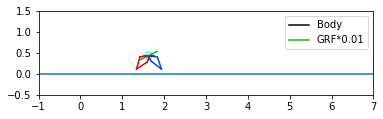

In [26]:
#animate it
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as ani
from IPython.display import HTML
%matplotlib inline

fig1, ax1 = plt.subplots(1,1) #create axes
ax1.set_aspect('equal')

# arrays to store values
N_time = []

def plot_robot(i,m,ax): #update function for animation
    ax.clear()
    ax.set_xlim([x_low_lim,x_high_lim+3.0])
    ax.set_ylim([y_low_lim,y_high_lim])
    N_time.append(i)
     
    plot_body = {}
    plot_url = {}
    plot_lrl = {}
    plot_ull = {}
    plot_lll = {}
    plot_foot = {}
    abs_angles = {}
    plot_FW = {}
    
    # plot body
    plot_body.update({('x_back'):m.q[i,'x_body'].value - 0.5*m.lengths['body']*cos(m.q[i,'theta_body'].value)})
    plot_body.update({('y_back'):m.q[i,'y_body'].value - 0.5*m.lengths['body']*sin(m.q[i,'theta_body'].value)})
    plot_body.update({('x_front'):m.q[i,'x_body'].value + 0.5*m.lengths['body']*cos(m.q[i,'theta_body'].value)})
    plot_body.update({('y_front'):m.q[i,'y_body'].value + 0.5*m.lengths['body']*sin(m.q[i,'theta_body'].value)})  
    ax.plot([plot_body['x_back'],plot_body['x_front']],[plot_body['y_back'],plot_body['y_front']],color='xkcd:black')

    # plot disc
    abs_angles.update({('disc'): m.q[i,'theta_body'].value + m.q[i,'theta_disc'].value})
    
    FW_disc = plt.Circle((m.q[i,'x_body'].value, m.q[i,'y_body'].value), disc_radius, color='cyan',fill = False )
    
    plot_FW.update({('x_back'):m.q[i,'x_body'].value - 0.5*5*disc_radius*cos(abs_angles['disc'])})
    plot_FW.update({('y_back'):m.q[i,'y_body'].value - 0.5*5*disc_radius*sin(abs_angles['disc'])})
    plot_FW.update({('x_front'):m.q[i,'x_body'].value + 0.5*5*disc_radius*cos(abs_angles['disc'])})
    plot_FW.update({('y_front'):m.q[i,'y_body'].value + 0.5*5*disc_radius*sin(abs_angles['disc'])})  
    ax.plot([plot_FW['x_back'],plot_FW['x_front']],[plot_FW['y_back'],plot_FW['y_front']],color='xkcd:green')
    ax.add_artist(FW_disc)
    
    for leg in legs:
        if leg == 'A':
            link_colour = ['blue','red']
        else:
            link_colour = ['red','purple']
        
        
        #plot upper right
        abs_angles.update({('RU',leg): m.q[i,'theta_body'].value + m.q[i,'theta_url'+leg].value})
        plot_url.update({('top','X',leg): m.q[i,'x_body'].value + 0.5*m.LL.value*cos(m.q[i,'theta_body'].value)})
        plot_url.update({('top','Y',leg): m.q[i,'y_body'].value + 0.5*m.LL.value*sin(m.q[i,'theta_body'].value)})
        plot_url.update({('bot','X',leg): m.q[i,'x_body'].value + 0.5*m.LL.value*cos(m.q[i,'theta_body'].value) - m.lengths['url'+leg]*cos(abs_angles['RU',leg])})
        plot_url.update({('bot','Y',leg): m.q[i,'y_body'].value + 0.5*m.LL.value*sin(m.q[i,'theta_body'].value) - m.lengths['url'+leg]*sin(abs_angles['RU',leg])})
        ax.plot([plot_url['top','X',leg],plot_url['bot','X',leg]],[plot_url['top','Y',leg],plot_url['bot','Y',leg]],color='xkcd:{0}'.format(link_colour[0]))
        
        #plot lower right
        abs_angles.update({('RL',leg): m.q[i,'theta_lrl'+leg].value - (np.pi-abs_angles['RU',leg])})
        plot_lrl.update({('top','X',leg): plot_url['bot','X',leg]})
        plot_lrl.update({('top','Y',leg): plot_url['bot','Y',leg]})
        plot_lrl.update({('bot','X',leg): plot_url['bot','X',leg] - m.lengths['lrl'+leg]*cos(abs_angles['RL',leg])})
        plot_lrl.update({('bot','Y',leg): plot_url['bot','Y',leg] - m.lengths['lrl'+leg]*sin(abs_angles['RL',leg])})
        ax.plot([plot_lrl['top','X',leg],plot_lrl['bot','X',leg]],[plot_lrl['top','Y',leg],plot_lrl['bot','Y',leg]],color='xkcd:{0}'.format(link_colour[0]))

        #plot upper left
        abs_angles.update({('LU',leg): m.q[i,'theta_body'].value + m.q[i,'theta_ull'+leg].value})
        plot_ull.update({('top','X',leg): m.q[i,'x_body'].value - 0.5*m.LL.value*cos(m.q[i,'theta_body'].value)})
        plot_ull.update({('top','Y',leg): m.q[i,'y_body'].value - 0.5*m.LL.value*sin(m.q[i,'theta_body'].value)})
        plot_ull.update({('bot','X',leg): m.q[i,'x_body'].value - 0.5*m.LL.value*cos(m.q[i,'theta_body'].value) - m.lengths['ull'+leg]*cos(abs_angles['LU',leg])})
        plot_ull.update({('bot','Y',leg): m.q[i,'y_body'].value - 0.5*m.LL.value*sin(m.q[i,'theta_body'].value) - m.lengths['ull'+leg]*sin(abs_angles['LU',leg])})
        ax.plot([plot_ull['top','X',leg],plot_ull['bot','X',leg]],[plot_ull['top','Y',leg],plot_ull['bot','Y',leg]],color='xkcd:{0}'.format(link_colour[0]))

        #plot lower left
        abs_angles.update({('LL',leg):m.q[i,'theta_lll'+leg].value - (np.pi-abs_angles['LU',leg])})
        plot_lll.update({('top','X',leg): plot_ull['bot','X',leg]})
        plot_lll.update({('top','Y',leg): plot_ull['bot','Y',leg]})
        plot_lll.update({('bot','X',leg): plot_ull['bot','X',leg] - m.lengths['lll'+leg]*cos(abs_angles['LL',leg])})
        plot_lll.update({('bot','Y',leg): plot_ull['bot','Y',leg] - m.lengths['lll'+leg]*sin(abs_angles['LL',leg])})
        ax.plot([plot_lll['top','X',leg],plot_lll['bot','X',leg]],[plot_lll['top','Y',leg],plot_lll['bot','Y',leg]],color='xkcd:{0}'.format(link_colour[0]))     
    
    
    if m.GRF_y[i,'A'].value > 0.0:
        #print('GRF_footR = ',m.GRF_y[i,'footR'].value)
        ax.arrow(plot_lll['bot','X','A'], plot_lll['bot','Y','A'], 0, 0.01*m.GRF_y[i,'A'].value,color='xkcd:{0}'.format('red'),head_width = 0.1)
        
    if m.GRF_y[i,'B'].value > 0.0:
        #print('GRF_footL = ',m.GRF_y[i,'footL'].value)
        ax.arrow(plot_lrl['bot','X','B'], plot_lrl['bot','Y','B'], 0, 0.01*m.GRF_y[i,'B'].value,color='xkcd:{0}'.format('red'),head_width = 0.1)
    
    ax.legend(["Body","GRF*0.01"], frameon=True)
    
    ax.plot([-10,10],[0,0]) # plot the ground
    
    
update = lambda i: plot_robot(i,m,ax1) # lambdify update function

animate = ani.FuncAnimation(fig1,update,range(1,N+1),interval = 50,repeat=True)

HTML(animate.to_html5_video()) #you need to convert the animation to HTML5 to embed it in the notebook


In [27]:
f = r"{0}_biped_FW.mp4".format(test) 
writervideo = ani.FFMpegWriter(fps=20) 
animate.save(f, writer=writervideo) 
vel = 0.0

nodes = []

xbody = []
ybody = []
thbody = []
thdisc = []
thullA = []
thurlA = []
thlllA = []
thlrlA = []
thullB = []
thurlB = []
thlllB = []
thlrlB = []



dxbody = []
dybody = []
dthbody = []
dthdisc = []
dthullA = []
dthurlA = []
dthlllA = []
dthlrlA = []
dthullB = []
dthurlB = []
dthlllB = []
dthlrlB = []

ddxbody = []
ddybody = []
ddthbody = []
ddthdisc = []
ddthullA = []
ddthurlA = []
ddthlllA = []
ddthlrlA = []
ddthullB = []
ddthurlB = []
ddthlllB = []
ddthlrlB = []

Torque_leftA = []
Torque_rightA = []
Torque_leftB = []
Torque_rightB = []
Torque_disc = []

GRF_y_A = []
GRF_y_B = []

angular_speed_leftA = []
angular_speed_rightA = []
angular_speed_leftB = []
angular_speed_rightB = []
angular_speed_disc = []



for n in range(1,N+1):
    
    xbody.append(m.q[n,'x_body'].value)
    ybody.append(m.q[n,'y_body'].value)
    thbody.append(m.q[n,'theta_body'].value)
    thdisc.append(m.q[n,'theta_disc'].value)
    thullA.append(m.q[n,'theta_ullA'].value) 
    thurlA.append(m.q[n,'theta_urlA'].value) 
    thlllA.append(m.q[n,'theta_lllA'].value) 
    thlrlA.append(m.q[n,'theta_lrlA'].value) 
    thullB.append(m.q[n,'theta_ullB'].value) 
    thurlB.append(m.q[n,'theta_urlB'].value) 
    thlllB.append(m.q[n,'theta_lllB'].value) 
    thlrlB.append(m.q[n,'theta_lrlB'].value) 

    dxbody.append(m.dq[n,'x_body'].value)
    dybody.append(m.dq[n,'y_body'].value)
    dthbody.append(m.dq[n,'theta_body'].value)
    dthdisc.append(m.dq[n,'theta_disc'].value)
    dthullA.append(m.dq[n,'theta_ullA'].value) 
    dthurlA.append(m.dq[n,'theta_urlA'].value) 
    dthlllA.append(m.dq[n,'theta_lllA'].value) 
    dthlrlA.append(m.dq[n,'theta_lrlA'].value) 
    dthullB.append(m.dq[n,'theta_ullB'].value) 
    dthurlB.append(m.dq[n,'theta_urlB'].value) 
    dthlllB.append(m.dq[n,'theta_lllB'].value) 
    dthlrlB.append(m.dq[n,'theta_lrlB'].value) 

    ddxbody.append(m.ddq[n,'x_body'].value)
    ddybody.append(m.ddq[n,'y_body'].value)
    ddthbody.append(m.ddq[n,'theta_body'].value)
    ddthdisc.append(m.ddq[n,'theta_disc'].value)
    ddthullA.append(m.ddq[n,'theta_ullA'].value) 
    ddthurlA.append(m.ddq[n,'theta_urlA'].value) 
    ddthlllA.append(m.ddq[n,'theta_lllA'].value) 
    ddthlrlA.append(m.ddq[n,'theta_lrlA'].value) 
    ddthullB.append(m.ddq[n,'theta_ullB'].value) 
    ddthurlB.append(m.ddq[n,'theta_urlB'].value) 
    ddthlllB.append(m.ddq[n,'theta_lllB'].value) 
    ddthlrlB.append(m.ddq[n,'theta_lrlB'].value) 

    Torque_leftA.append(m.tau_torque[n,'left','A'].value)
    Torque_rightA.append(m.tau_torque[n,'right','A'].value)
    Torque_leftB.append(m.tau_torque[n,'left','B'].value)
    Torque_rightB.append(m.tau_torque[n,'right','B'].value)
    Torque_disc.append(m.tau_torque_FW[n].value)
    

    GRF_y_A.append(m.GRF_y[n,'A'].value)
    GRF_y_B.append(m.GRF_y[n,'B'].value)

    angular_speed_leftA.append(m.tau_velocity[n,'left','A'].value) 
    angular_speed_rightA.append(m.tau_velocity[n,'right','A'].value)
    angular_speed_leftB.append(m.tau_velocity[n,'left','B'].value)
    angular_speed_rightB.append(m.tau_velocity[n,'right','B'].value)
    angular_speed_disc.append(m.tau_velocity_FW[n].value)
    
    nodes.append(n)
    
    
    #print(m.q[n,'y_body'].value)
    #print(m.q[n,'{r_prismatic}_{footL}'].value)
    #print(m.foot_position[n, 'Y', 'footR'].value)
    #print(m.q[n,'y_body'].value)
    #print(m.dq[n,'x_body'].value)
    #vel = vel + m.dq[n,'x_body'].value
    #print(m.GRF_y[n,'footL'].value)
    #print(m.tau_torque[n,'left'].value)
    pass



''' Store first values in csv file '''
import csv
# csv_file_name = str(int(V_avg))+'_u{0}'.format(mu_value)
csv_file_name = "Test_{0}_N_{1}_TT_{2}".format(test,N,str(int(TT)))

heading0 = ['node']
heading1 = ['x_body','y_body','theta_body','theta_disc','theta_ullA','theta_urlA','theta_lllA','theta_lrlA','theta_ullB','theta_urlB','theta_lllB','theta_lrlB']
heading2 = ['dx_body','dy_body','dtheta_body','dtheta_disc','dtheta_ullA','dtheta_urlA','dtheta_lllA','dtheta_lrlA','dtheta_ullB','dtheta_urlB','dtheta_lllB','dtheta_lrlB']
heading3 = ['ddx_body','ddy_body','ddtheta_body','ddtheta_disc','ddtheta_ullA','ddtheta_urlA','ddtheta_lllA','ddtheta_lrlA','ddtheta_ullB','ddtheta_urlB','ddtheta_lllB','ddtheta_lrlB']
heading4 = ['Tau_leftA','Tau_rightA','Tau_leftB','Tau_rightB', 'Tau_disc','GRF_yA','GRF_yB']
heading = heading0 + heading1 + heading2 + heading3 + heading4

with open(csv_file_name+'.csv', 'w') as f:
    writer = csv.writer(f)

    writer.writerow(heading)

    for n in range(N):
        node = [n]
        data1 = [xbody[n],ybody[n],thbody[n],thdisc[n],thullA[n],thurlA[n],thlllA[n],thlrlA[n],thullB[n],thurlB[n],thlllB[n],thlrlB[n]]
        data2 = [dxbody[n],dybody[n],dthbody[n],dthdisc[n],dthullA[n],dthurlA[n],dthlllA[n],dthlrlA[n],dthullB[n],dthurlB[n],dthlllB[n],dthlrlB[n]]
        data3 = [ddxbody[n],ddybody[n],ddthbody[n],ddthdisc[n],ddthullA[n],ddthurlA[n],ddthlllA[n],ddthlrlA[n],ddthullB[n],ddthurlB[n],ddthlllB[n],ddthlrlB[n]]
        data4 = [Torque_leftA[n],Torque_rightA[n],Torque_leftB[n],Torque_rightB[n],Torque_disc[n],GRF_y_A[n],GRF_y_B[n]]
        data = node + data1 + data2 + data3 + data4
        writer.writerow(data)
        
csv_file_name2 = "Test_{0}_N_{1}_TT_{2}".format(test,N,str(int(TT)))        
with open("NOTE_"+csv_file_name2 + ".csv" , 'w') as f:
    writer = csv.writer(f)
    writer.writerow(['ground_penalty','status','mu','TT','N','h_lower','h_higher'])
    writer.writerow([pen_sum,results.solver.termination_condition,mu_value,TT,N,h_lower_bound,h_higher_bound])
        
    

In [28]:
for n in range(N):
    print(dthdisc[n])

-5.697242500283255
-5.271584008338155
-4.5242050744474565
-4.4817574843346994
-4.447808422988226
-4.130630735676969
-4.070352582693766
-4.268634890910687
-4.720232247363156
-5.297093116758862
-5.688282113202514
-5.715465649507836
-5.914070293166257
-5.909910995074253
-5.904977822867134
-5.897154759632136
-5.886498863665689
-5.873043562359916
-5.856798252643268
-5.837748641075353
-5.815857711283331
-5.791067213269749
-5.763299588045391
-5.732460260790346
-5.6984402540824695
-5.661119087733947
-5.620367942180419
-5.576053067168912
-5.528039415675084
-5.4761944727485234
-5.420392226921669
-5.360517191458334
-5.296468311639364
-5.228162469628753
-5.155537076194199
-5.078550837771909
-4.997181046033489
-4.911414342308212
-4.821225214563922
-4.726531133725197
-4.627102256217281
-4.522380529251729
-4.411109018144409
-4.290552274787314
-2.256611363001754
-3.304914021896866
-2.5579944262977654
-1.846155308942715
-1.167123257671058
-0.5234191934296342
0.08288057675009977
0.6493426870031681
1.190

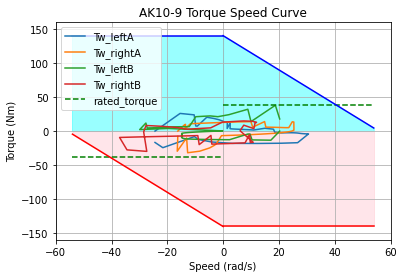

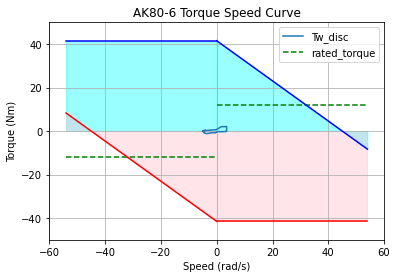

In [29]:
plt.figure()
plt.plot(angular_speed_leftA,Torque_leftA)
plt.plot(angular_speed_rightA,Torque_rightA)
plt.plot(angular_speed_leftB,Torque_leftB)
plt.plot(angular_speed_rightB,Torque_rightB)

plt.grid()
plt.plot(x_p,rated_torque_p,color = 'green',linestyle = '--')
plt.plot(x_n,rated_torque_n,color = 'green',linestyle = '--')

plt.plot(x_p, y_p,'b')
plt.plot(x_n, stall_torque_p,'b')

plt.fill_between(x_p, y_p, alpha=0.4, color = 'cyan')
plt.fill_between(x_n, stall_torque_p, alpha=0.4,color = 'cyan')

plt.plot(x_n, y_n,'r')
plt.plot(x_p, stall_torque_n,'r')

plt.fill_between(x_n, y_n, alpha=0.4,color = 'pink')
plt.fill_between(x_p, stall_torque_n, alpha=0.4,color = 'pink')

plt.axis((-60,60,-160,160))
plt.title('AK10-9 Torque Speed Curve')
plt.xlabel('Speed (rad/s)')
plt.ylabel('Torque (Nm)')
plt.legend(["Tw_leftA", "Tw_rightA","Tw_leftB", "Tw_rightB","rated_torque"], loc=0, frameon=True)

###################################
plt.figure()
plt.plot(angular_speed_disc,Torque_disc)

plt.grid()
plt.plot(x_p,rated_torque_p_FW,color = 'green',linestyle = '--')
plt.plot(x_n,rated_torque_n_FW,color = 'green',linestyle = '--')

plt.plot(x_p, y_p_FW,'b')
plt.plot(x_n, stall_torque_p_FW,'b')

plt.fill_between(x_p, y_p_FW, alpha=0.4, color = 'cyan')
plt.fill_between(x_n, stall_torque_p_FW, alpha=0.4,color = 'cyan')

plt.plot(x_n, y_n_FW,'r')
plt.plot(x_p, stall_torque_n_FW,'r')

plt.fill_between(x_n, y_n_FW, alpha=0.4,color = 'pink')
plt.fill_between(x_p, stall_torque_n_FW, alpha=0.4,color = 'pink')

plt.axis((-60,60,-50,50))
plt.title('AK80-6 Torque Speed Curve')
plt.xlabel('Speed (rad/s)')
plt.ylabel('Torque (Nm)')
plt.legend(["Tw_disc","rated_torque"], loc=0, frameon=True)

In [30]:
# try: 
#     # solving
#     opt = SolverFactory('ipopt',executable = '/home/uct/Trajectory_Optimization/IPOPT/build/bin/ipopt')
#     opt.options["linear_solver"] = 'ma86'

#     # solver options
#     opt.options["expect_infeasible_problem"] = 'yes'
#     #pt.options["linear_system_scaling"] = 'none'
#     #opt.options["mu_strategy"] = "adaptive"
#     opt.options["print_level"] = 5     # prints a log with each iteration (you want to this - it's the only way to see progress.)
#     opt.options["max_iter"] = 30000*10   # maximum number of iterations
#     opt.options["max_cpu_time"] = 600*10  # maximum cpu time in seconds
#     opt.options["Tol"] = 1e-6          # the tolerance for feasibility. Considers constraints satisfied when they're within this margin.

#     results = opt.solve(m, tee = True)

#     ###########################################################################################################

#     # PLOT COST FUNCTION -------------------------------------------------------------------------------------------------------------
#     # T = sum(m.h[n] for n in range(1,N+1))
#     pen_sum = 0.0
#     for n in range(1,N+1):
#             for gc in ground_constraints:
#                 for leg in legs:
#                     pen_sum += m.ground_penalty[n,gc,leg].value
#     print(pen_sum)

#     ###########################################################################################################

#     #animate it
#     import matplotlib
#     import matplotlib.pyplot as plt
#     import matplotlib.animation as ani
#     from IPython.display import HTML
#     %matplotlib inline

#     fig1, ax1 = plt.subplots(1,1) #create axes
#     ax1.set_aspect('equal')

#     # arrays to store values
#     N_time = []

#     def plot_robot(i,m,ax): #update function for animation
#         ax.clear()
#         ax.set_xlim([x_low_lim,x_high_lim])
#         ax.set_ylim([y_low_lim,y_high_lim])
#         N_time.append(i)

#         plot_body = {}
#         plot_url = {}
#         plot_lrl = {}
#         plot_ull = {}
#         plot_lll = {}
#         plot_foot = {}
#         abs_angles = {}

#         # plot body
#         plot_body.update({('x_back'):m.q[i,'x_body'].value - 0.5*m.lengths['body']*cos(m.q[i,'theta_body'].value)})
#         plot_body.update({('y_back'):m.q[i,'y_body'].value - 0.5*m.lengths['body']*sin(m.q[i,'theta_body'].value)})
#         plot_body.update({('x_front'):m.q[i,'x_body'].value + 0.5*m.lengths['body']*cos(m.q[i,'theta_body'].value)})
#         plot_body.update({('y_front'):m.q[i,'y_body'].value + 0.5*m.lengths['body']*sin(m.q[i,'theta_body'].value)})  
#         ax.plot([plot_body['x_back'],plot_body['x_front']],[plot_body['y_back'],plot_body['y_front']],color='xkcd:black')

#         for leg in legs:
#             if leg == 'A':
#                 link_colour = ['blue','red']
#             else:
#                 link_colour = ['red','purple']


#             #plot upper right
#             abs_angles.update({('RU',leg): m.q[i,'theta_body'].value + m.q[i,'theta_url'+leg].value})
#             plot_url.update({('top','X',leg): m.q[i,'x_body'].value + 0.5*m.LL.value*cos(m.q[i,'theta_body'].value)})
#             plot_url.update({('top','Y',leg): m.q[i,'y_body'].value + 0.5*m.LL.value*sin(m.q[i,'theta_body'].value)})
#             plot_url.update({('bot','X',leg): m.q[i,'x_body'].value + 0.5*m.LL.value*cos(m.q[i,'theta_body'].value) - m.lengths['url'+leg]*cos(abs_angles['RU',leg])})
#             plot_url.update({('bot','Y',leg): m.q[i,'y_body'].value + 0.5*m.LL.value*sin(m.q[i,'theta_body'].value) - m.lengths['url'+leg]*sin(abs_angles['RU',leg])})
#             ax.plot([plot_url['top','X',leg],plot_url['bot','X',leg]],[plot_url['top','Y',leg],plot_url['bot','Y',leg]],color='xkcd:{0}'.format(link_colour[0]))

#             #plot lower right
#             abs_angles.update({('RL',leg): m.q[i,'theta_lrl'+leg].value - (np.pi-abs_angles['RU',leg])})
#             plot_lrl.update({('top','X',leg): plot_url['bot','X',leg]})
#             plot_lrl.update({('top','Y',leg): plot_url['bot','Y',leg]})
#             plot_lrl.update({('bot','X',leg): plot_url['bot','X',leg] - m.lengths['lrl'+leg]*cos(abs_angles['RL',leg])})
#             plot_lrl.update({('bot','Y',leg): plot_url['bot','Y',leg] - m.lengths['lrl'+leg]*sin(abs_angles['RL',leg])})
#             ax.plot([plot_lrl['top','X',leg],plot_lrl['bot','X',leg]],[plot_lrl['top','Y',leg],plot_lrl['bot','Y',leg]],color='xkcd:{0}'.format(link_colour[0]))

#             #plot upper left
#             abs_angles.update({('LU',leg): m.q[i,'theta_body'].value + m.q[i,'theta_ull'+leg].value})
#             plot_ull.update({('top','X',leg): m.q[i,'x_body'].value - 0.5*m.LL.value*cos(m.q[i,'theta_body'].value)})
#             plot_ull.update({('top','Y',leg): m.q[i,'y_body'].value - 0.5*m.LL.value*sin(m.q[i,'theta_body'].value)})
#             plot_ull.update({('bot','X',leg): m.q[i,'x_body'].value - 0.5*m.LL.value*cos(m.q[i,'theta_body'].value) - m.lengths['ull'+leg]*cos(abs_angles['LU',leg])})
#             plot_ull.update({('bot','Y',leg): m.q[i,'y_body'].value - 0.5*m.LL.value*sin(m.q[i,'theta_body'].value) - m.lengths['ull'+leg]*sin(abs_angles['LU',leg])})
#             ax.plot([plot_ull['top','X',leg],plot_ull['bot','X',leg]],[plot_ull['top','Y',leg],plot_ull['bot','Y',leg]],color='xkcd:{0}'.format(link_colour[0]))

#             #plot lower left
#             abs_angles.update({('LL',leg):m.q[i,'theta_lll'+leg].value - (np.pi-abs_angles['LU',leg])})
#             plot_lll.update({('top','X',leg): plot_ull['bot','X',leg]})
#             plot_lll.update({('top','Y',leg): plot_ull['bot','Y',leg]})
#             plot_lll.update({('bot','X',leg): plot_ull['bot','X',leg] - m.lengths['lll'+leg]*cos(abs_angles['LL',leg])})
#             plot_lll.update({('bot','Y',leg): plot_ull['bot','Y',leg] - m.lengths['lll'+leg]*sin(abs_angles['LL',leg])})
#             ax.plot([plot_lll['top','X',leg],plot_lll['bot','X',leg]],[plot_lll['top','Y',leg],plot_lll['bot','Y',leg]],color='xkcd:{0}'.format(link_colour[0]))     


#         if m.GRF_y[i,'A'].value > 0.0:
#             #print('GRF_footR = ',m.GRF_y[i,'footR'].value)
#             ax.arrow(plot_lll['bot','X','A'], plot_lll['bot','Y','A'], 0, 0.01*m.GRF_y[i,'A'].value,color='xkcd:{0}'.format('red'),head_width = 0.1)

#         if m.GRF_y[i,'B'].value > 0.0:
#             #print('GRF_footL = ',m.GRF_y[i,'footL'].value)
#             ax.arrow(plot_lrl['bot','X','B'], plot_lrl['bot','Y','B'], 0, 0.01*m.GRF_y[i,'B'].value,color='xkcd:{0}'.format('red'),head_width = 0.1)

#         ax.legend(["Body","GRF*0.01"], frameon=True)

#         ax.plot([-10,10],[0,0]) # plot the ground


#     update = lambda i: plot_robot(i,m,ax1) # lambdify update function

#     animate = ani.FuncAnimation(fig1,update,range(1,N+1),interval = 50,repeat=True)

#     HTML(animate.to_html5_video()) #you need to convert the animation to HTML5 to embed it in the notebook

#     ###########################################################################################################

#     import os

#     # Directory
#     directory = "Test_{0}_N_{1}_TT_{2}".format(test,N,str(int(TT)))

#     # Parent Directory path
#     parent_dir = "BRAKING_8ms"

#     # Path
#     path = os.path.join(parent_dir, directory) 
#     os.mkdir(path)

#     csv_file_name = directory
#     #with open(os.path.join(parent_dir, directory,directory)+'.csv', 'w') as f:
#     with open("BRAKING_8ms/{0}/Results.csv".format(directory) , 'w') as f:
#         writer = csv.writer(f)
#         writer.writerow(['ground_penalty','status','mu','TT','N','h_lower','h_higher'])
#         writer.writerow([pen_sum,results.solver.termination_condition,mu_value,TT,N,h_lower_bound,h_higher_bound])

#     import csv
#     #csv_file_name = str(int(V_avg))+'.csv'

#     heading0 = ['node']
#     heading1 = ['x_body','y_body','theta_body','theta_ullA','theta_urlA','theta_lllA','theta_lrlA','theta_ullB','theta_urlB','theta_lllB','theta_lrlB']
#     heading2 = ['dx_body','dy_body','dtheta_body','dtheta_ullA','dtheta_urlA','dtheta_lllA','dtheta_lrlA','dtheta_ullB','dtheta_urlB','dtheta_lllB','dtheta_lrlB']
#     heading3 = ['ddx_body','ddy_body','ddtheta_body','ddtheta_ullA','ddtheta_urlA','ddtheta_lllA','ddtheta_lrlA','ddtheta_ullB','ddtheta_urlB','ddtheta_lllB','ddtheta_lrlB']
#     heading4 = ['Tau_leftA','Tau_rightA','Tau_leftB','Tau_rightB']
#     heading = heading0 + heading1 + heading2 + heading3 + heading4

#     with open("BRAKING_8ms/{0}/Data.csv".format(directory), 'w') as f:
#         writer = csv.writer(f)

#         writer.writerow(heading)

#         for n in range(N):
#             node = [n]
#             data1 = [xbody[n],ybody[n],thbody[n],thullA[n],thurlA[n],thlllA[n],thlrlA[n],thullB[n],thurlB[n],thlllB[n],thlrlB[n]]
#             data2 = [dxbody[n],dybody[n],dthbody[n],dthullA[n],dthurlA[n],dthlllA[n],dthlrlA[n],dthullB[n],dthurlB[n],dthlllB[n],dthlrlB[n]]
#             data3 = [ddxbody[n],ddybody[n],ddthbody[n],ddthullA[n],ddthurlA[n],ddthlllA[n],ddthlrlA[n],ddthullB[n],ddthurlB[n],ddthlllB[n],ddthlrlB[n]]
#             data4 = [Torque_leftA[n],Torque_rightA[n],Torque_leftB[n],Torque_rightB[n]]
#             data = node + data1 + data2 + data3 + data4
#             writer.writerow(data)    

#     plt.figure()
#     plt.plot(angular_speed_leftA,Torque_leftA)
#     plt.plot(angular_speed_rightA,Torque_rightA)
#     plt.plot(angular_speed_leftB,Torque_leftB)
#     plt.plot(angular_speed_rightB,Torque_rightB)

#     plt.grid()
#     plt.plot(x_p,rated_torque_p,color = 'green',linestyle = '--')
#     plt.plot(x_n,rated_torque_n,color = 'green',linestyle = '--')

#     plt.plot(x_p, y_p,'b')
#     plt.plot(x_n, stall_torque_p,'b')

#     plt.fill_between(x_p, y_p, alpha=0.4, color = 'cyan')
#     plt.fill_between(x_n, stall_torque_p, alpha=0.4,color = 'cyan')

#     plt.plot(x_n, y_n,'r')
#     plt.plot(x_p, stall_torque_n,'r')

#     plt.fill_between(x_n, y_n, alpha=0.4,color = 'pink')
#     plt.fill_between(x_p, stall_torque_n, alpha=0.4,color = 'pink')

#     plt.axis((-60,60,-160,160))
#     plt.title('New Torque Speed Curve')
#     plt.xlabel('Speed (rad/s)')
#     plt.ylabel('Torque (Nm)')
#     plt.legend(["Tw_leftA", "Tw_rightA","Tw_leftB", "Tw_rightB","rated_torque"], loc=0, frameon=True)
#     plt.savefig("BRAKING_8ms/{0}/Torque_Speed.jpg".format(directory))

#     f = r"BRAKING_8ms/{0}/{1}_biped.mp4".format(directory,test) 
#     writervideo = ani.FFMpegWriter(fps=20) 
#     animate.save(f, writer=writervideo)   
# except:
#     pass

In [31]:
N

100

In [32]:
m.connect_force[50,'Y','B'].value

-51.18418446748468

In [33]:
m.dq[1,'x_body'].value

8.099066276995277

In [34]:
<a href='#initial_conditions'>Link to initial conditions'</a>

<a href='#Select_Test'>Link to Test Selection'</a>

SyntaxError: invalid syntax (<ipython-input-34-4dfaa2b26d24>, line 1)